In [ ]:
%pwd
%cd ..

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import os 

from wilcoxon_signed_rank import *

import warnings
warnings.filterwarnings('ignore')

In [3]:
path_task = os.getcwd()

path_image = path_task + 'image/' # Folder to save image 
path_csv_results = path_task + 'results_csv/' # Folder to save experiments csv


In [4]:
results_df_all = pd.read_csv(path_csv_results + 'Result-Thresh-Opt_resampling.csv')

## Other Implementations 

In [5]:
def _check_result_table(df):
    
    #check missing values 
    assert df.isnull().sum().sum() == 0
    #check column name and format 
    pass
    #check length
    pass

def _formatting_numericcol_table(df):

    #column names to convert to numeric
    cols  = ['Optimal_threshold', 'Cheat threshold evaluation',
                   'Optimal score_optimization set', 'Optimal score_evaluation', 'Cheat score evaluation', "f1-score_evaluation",  "gmean_evaluation", "youden_evaluation", 'recall-score_evaluation', 'precision-score_evaluation', 
                   'accuracy-score_evaluation', 'specificity-score_evaluation', 'fpr-score_evaluation','tpr-score_evaluation']
    df_copy = df.copy()
    df_copy[cols] = df[cols].apply(pd.to_numeric)
        
    return df_copy


### Average behavior of different cases

Here we compare performances on evaluation set for different cases of optimization set, by using the **average** of the scores in each case. We notice that mean comparison is in general not a good way of comparing, due to possible outliers, and other reasons. So in next section we will use our protocol of comparison with the Wilcoxon signed ranks test. 

The green cells means that the case corresponding to the row has better, in average, metric score than the case corresponding the column.
The red cells means that the case corresponding to the row has , in average, metric score than the case corresponding the column.
The white cells means that the case corresponding to the row has equal average metric score than the case corresponding the column.

Metric score (either f1, gmean, recall, precision or specificity) are listed in ordered (see title of graph).

In [6]:
def average_result_table(df, average_type='all'):
    #check missing values
    _check_result_table(df)
    
    #convert numeric type columns
    df = _formatting_numericcol_table(df)

    #group by model, case and approach  then averaging metrics score
    if average_type == 'monitor-case-metric':
        df_average = df.groupby(['Monitor', 'Case', 'Optimal approach'], as_index=False).mean(numeric_only=True)
    elif average_type == 'model-monitor-case-metric':
        df_average = df.groupby(['Model', 'Monitor', 'Case', 'Optimal approach'], as_index=False).mean(numeric_only=True)
    elif average_type == 'model-monitor-ood-case-metric':
        df_average = df.groupby(['Model', 'Monitor', 'OOD Type', 'Case', 'Optimal approach'], as_index=False).mean(numeric_only=True)
    else:
        raise Exception("Funciton requires average_type, check definition for mor information")
        
    return df_average


def pairwise_comparison_pvalue(res_pvalue, flag, metric_name, monitor_concerned=[], ax_plot=None, annot=True, 
                               heatmap_title_display=False, app='f1'):
    # Getting the Upper Triangle of the co-relation matrix
    matrix_pvalue = np.tril(np.ones_like(res_pvalue, dtype=bool))
    
    # Define RGB color 
    red = (0.8, 0.0, 0.0, 1.0) # Red cells = the case corresponding to the row is worst than the column
    green = (0.0, 0.8, 0.0, 1.0) # Green cells = the case corresponding to the row is better than the column
    
    dim_compare = len(res_pvalue)
    
    ax_plot = sns.heatmap(res_pvalue, annot=annot, mask=matrix_pvalue, fmt='.1e', 
                     square=True,annot_kws={'rotation': 45},
                     xticklabels=[f'Case{i}' for i in range(dim_compare)],
                     yticklabels=[f'Case{i}' for i in range(dim_compare)], 
                     cmap=ListedColormap(['white']), cbar=False, ax=ax_plot)

    ax_plot = sns.heatmap(res_pvalue, annot=annot, mask=(flag!=1)|matrix_pvalue, fmt='.1e', 
                     square=True,annot_kws={'rotation': 45},
                     xticklabels=[f'Case{i}' for i in range(dim_compare)], 
                     yticklabels=[f'Case{i}' for i in range(dim_compare)], 
                     cmap=ListedColormap(green), cbar=False, ax = ax_plot)

    ax_plot = sns.heatmap(res_pvalue, annot=annot, mask=(flag!=-1)|matrix_pvalue, fmt='.1e', 
                     square=True,annot_kws={'rotation': 45},
                     xticklabels=[f'Case{i}' for i in range(dim_compare)], 
                     yticklabels=[f'Case{i}' for i in range(dim_compare)], 
                     cmap=ListedColormap(red), cbar=False, ax = ax_plot, 
                    linewidths=0.5, linecolor='white')

    ax_plot.patch.set_facecolor('gray')
    if heatmap_title_display:
#         ax_plot.set_title(f'Threshold optimized in {app} sense \
#                     \n Metric compared: {metric_name} \
#                      ' + f"\n Monitor included: {monitor_concerned}" * len(monitor_concerned))
         ax_plot.set_title(f'Metric: {metric_name}') 
    return ax_plot 

def multiple_pariwise_comparison_correction(pvalue_list, alpha=0.05, method='bonferroni'):
    
    reject_H0 = [False for _ in range(len(pvalue_list))]
    if method == 'bonferroni':
        num_comparison = len(pvalue_list)
        adjusted_level = alpha/num_comparison

        for i in range(len(pvalue_list)):
            if pvalue_list[i]<=alpha:
                reject_H0[i] = True
    
    elif method == 'holm-bonferroni':
        pvalue_list = np.array(pvalue_list)
        idx_sorting =  np.argsort(pvalue_list)
        p_value_sorted = pvalue_list[idx_sorting]
        
        for i in range(len(p_value_sorted)):
            adjusted_level = alpha/(len(p_value_sorted)-i)
            if p_value_sorted[i]>alpha:
                break
            else: 
                reject_H0[np.where(idx_sorting==i)[0][0]]=True
    else: 
        raise Exception('Error: Method of correction not found.')
    
    return reject_H0
        

In [7]:
average_type = 'monitor-case-metric' # group by these cols to get average
results_df_process = average_result_table(results_df_all, average_type=average_type)

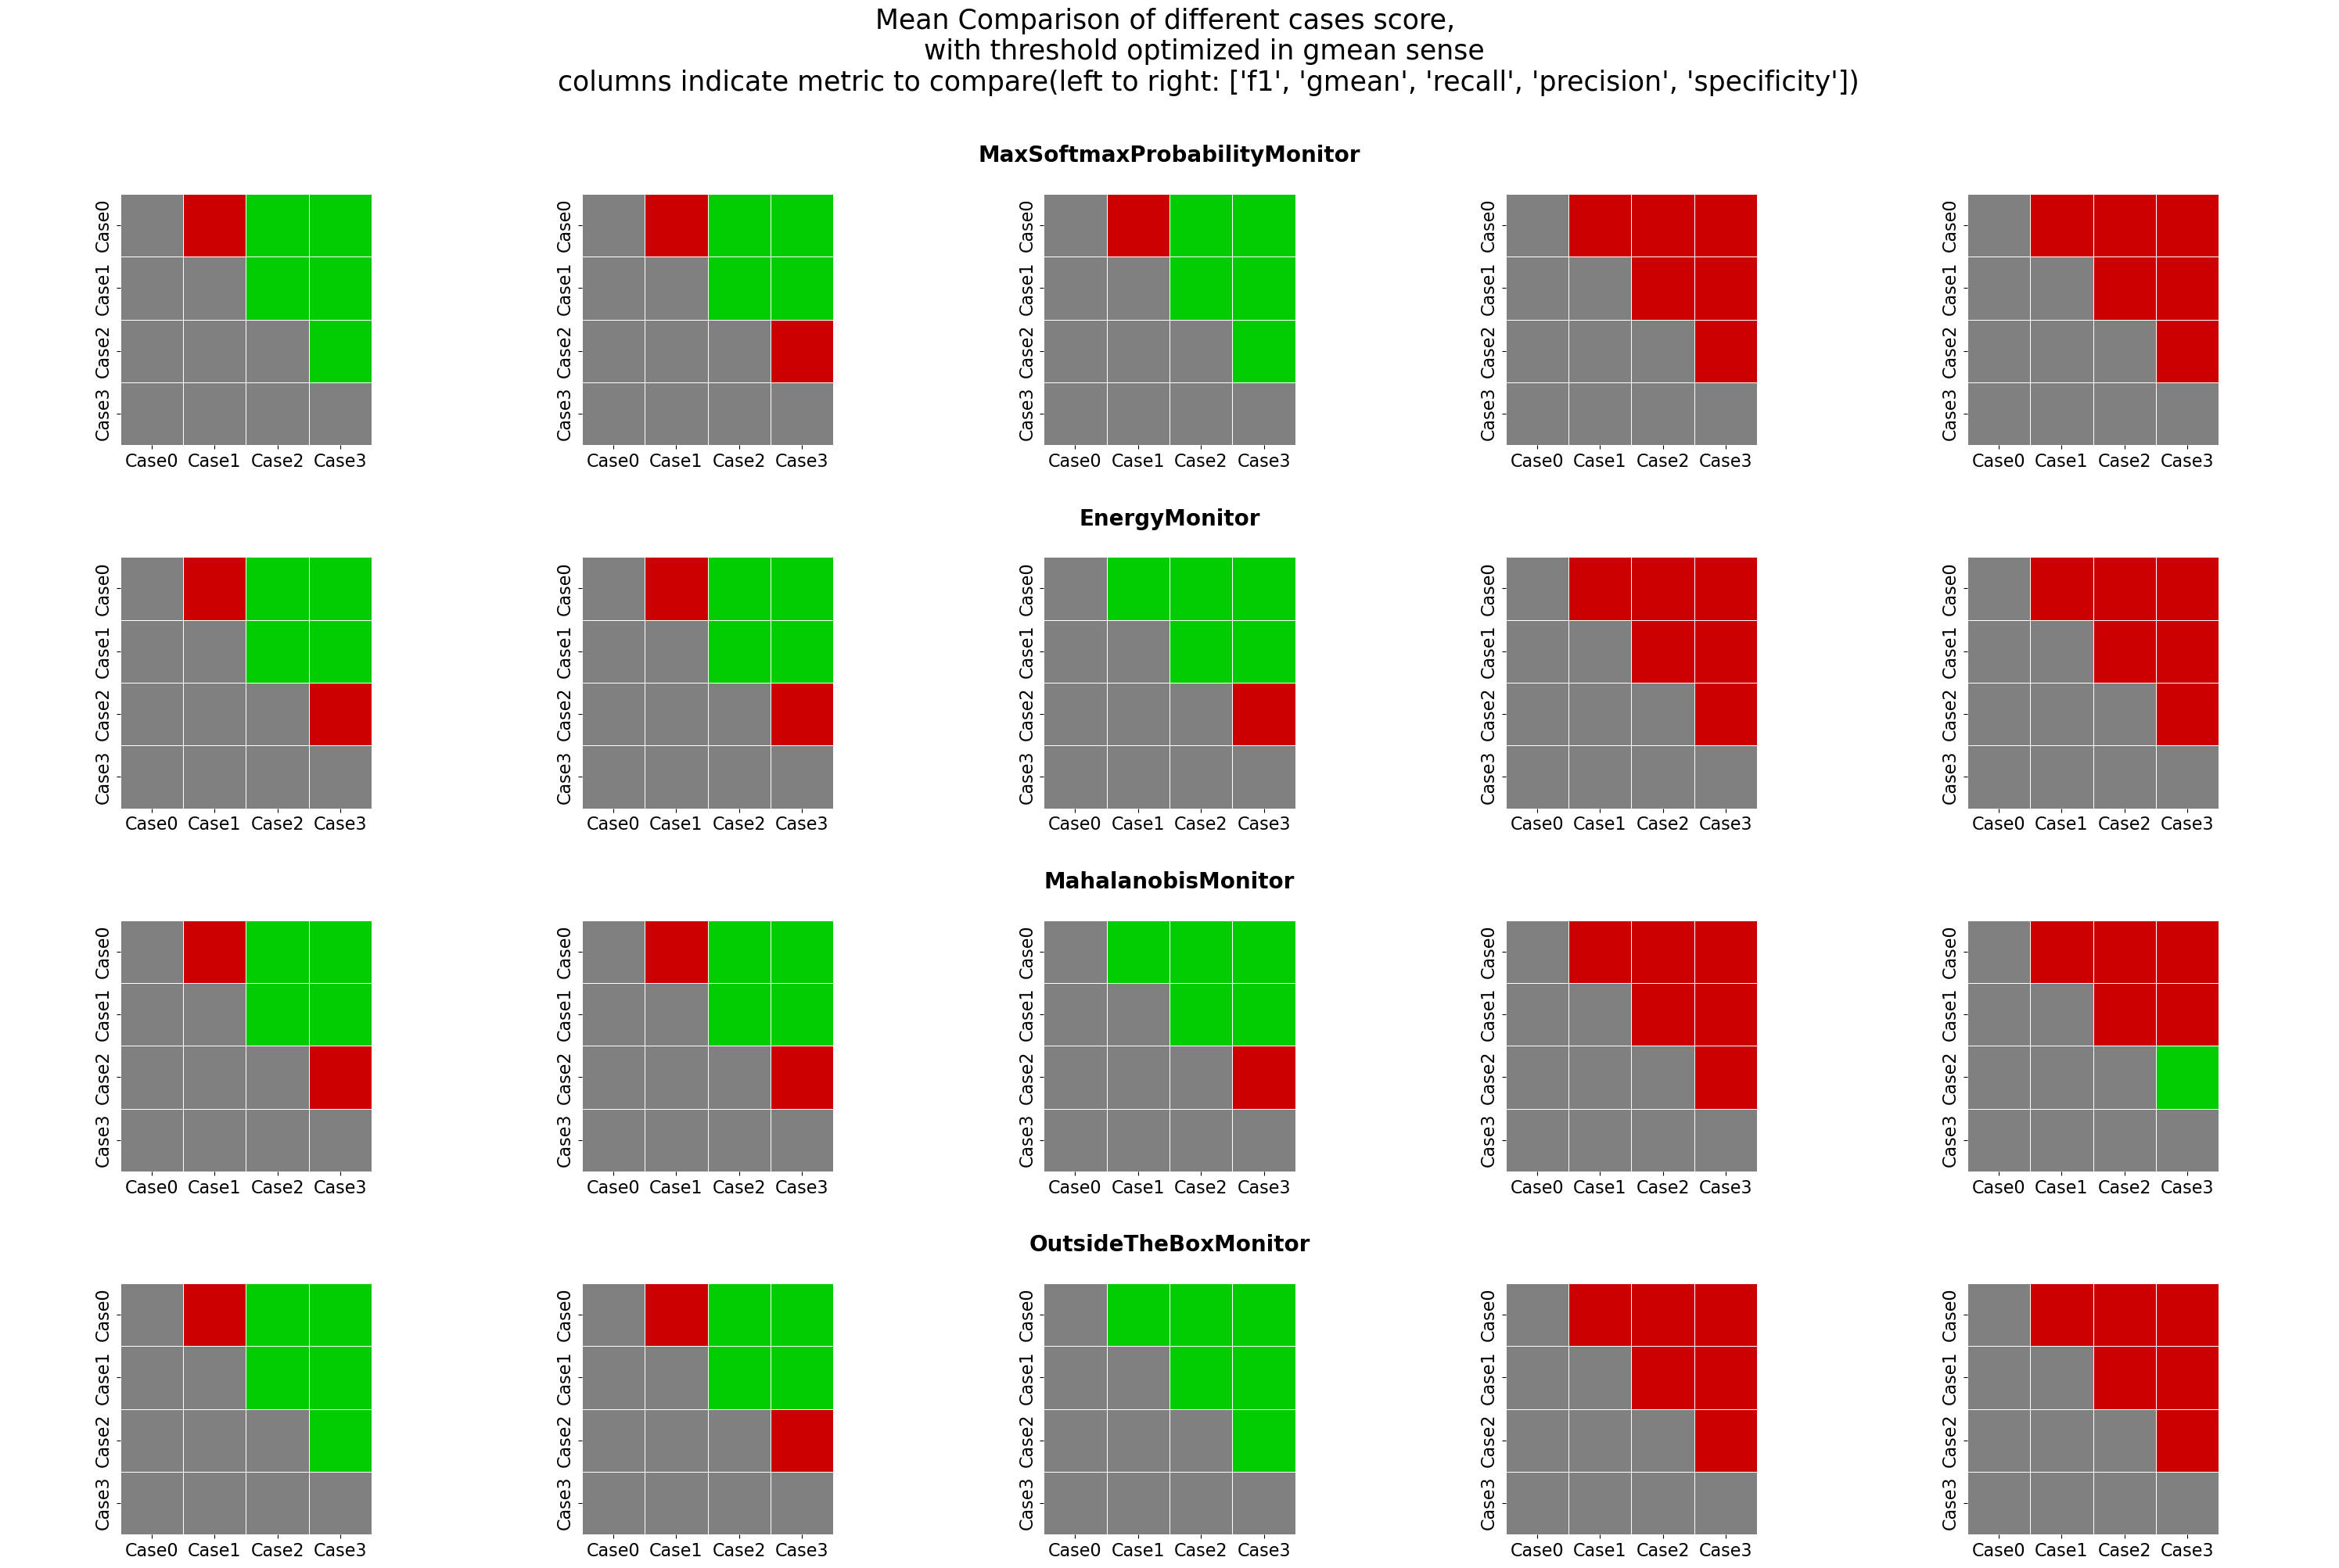

In [8]:
###
plt.rcParams["figure.figsize"] = [30, 20]


monitor_concerned_list = ['MaxSoftmaxProbabilityMonitor', 'EnergyMonitor', 'MahalanobisMonitor', 'OutsideTheBoxMonitor'] # 
app='gmean'

metrics_compare = ['f1', 'gmean', 'recall', 'precision', 'specificity']
metrics_compare_colname = ["f1-score_evaluation",  "gmean_evaluation", 
                           'recall-score_evaluation', 'precision-score_evaluation', 'specificity-score_evaluation']
assert len(metrics_compare) == len(metrics_compare_colname)

f, axes = plt.subplots(len(monitor_concerned_list), len(metrics_compare_colname))
f.suptitle(f'Mean Comparison of different cases score, \n \
        with threshold optimized in {app} sense \n \
        columns indicate metric to compare(left to right: {metrics_compare})',fontsize=25, y= 1)

case_permute = [0, 1, 3, 2]
real_case_name = ["ID", 'ID+T', 'ID+O', 'ID+T+O']

for no_monitor, monitor_concerned in enumerate(monitor_concerned_list):
    result_to_compare = results_df_process[results_df_process["Monitor"].isin([monitor_concerned])]
    result_to_compare_app = result_to_compare[result_to_compare['Optimal approach']==app]
    
    for no_metric, col in enumerate(metrics_compare_colname):
        res_statistic = np.zeros((4, 4))
        res_pvalue = np.zeros((4, 4))
        flag =  np.zeros((4, 4)) # -1 if less, +1 if greater, 0 if equal 
        
        for i in range(4):
            average_i = result_to_compare_app[result_to_compare_app["Case"]==f'Case{case_permute[i]}'][col].tolist()[0]
            for j in range(4):
                if j==i:
                    continue
                average_j = result_to_compare_app[result_to_compare_app["Case"]==f'Case{case_permute[j]}'][col].tolist()[0]

                # compare if 2 cases have same app average score
                if average_i == average_j:
                    pass
                elif average_i > average_j:
                    flag[i, j] = 1
                else:
                    flag[i, j] = -1
                
        ax = pairwise_comparison_pvalue(res_pvalue, flag, metric_name=col, monitor_concerned=[monitor_concerned], 
                                        ax_plot=axes[no_monitor, no_metric], app=app, annot=False)
        for item in ([axes[no_monitor, no_metric].title, axes[no_monitor, no_metric].xaxis.label, axes[no_monitor, no_metric].yaxis.label] +
                     axes[no_monitor, no_metric].get_xticklabels() + axes[no_monitor, no_metric].get_yticklabels()):
            item.set_fontsize('16')
             
# Add title of each row (each monitor)               
grid = plt.GridSpec(len(monitor_concerned_list), len(metrics_compare_colname))
for i in range(len(monitor_concerned_list)):
    create_subtitle(f, grid[i, ::], f'{monitor_concerned_list[i]}', y_posi=1, fontweight='semibold', fontsize=20)

plt.tight_layout()
plt.show()

### Wilcoxon signed ranks test for different cases

We try here another strategy of comparison of performance between cases, here we implement pair-wise (comparison of 2 monitors corresponding to 2 categories over multiple datasets). For multi comparison problem, we implement Boferronni correction with results obtained by Wilcoxon signed rank test.

To compare performances on one evaluation set of monitors trained on different datasets, we will use here the Wilcoxon signed ranks test to know if the performance of monitor trained with strategy A is stochastically better or not to the performance of monitor trained with strategy B. 


Concretely, we extract the relevant scores on evaluation set that we want to compare, if we denote the 2 monitors $i$ and $j$, then we will:
- Do first test to know if $i$ and $j$ have equal or not distribution  
    If not, then:
    + Compare average rank of A and B to know if $i > j$ or if $i < j$ 
    
- if $i = j$, white cell
- if <font color='green'>$i > j$</font>, <font color='green'>green</font> cell
- if <font color='red'>$i < j$</font>, <font color='red'>red</font> cell


We show below the statistic comparison of different cases, to know if for each pair of cases, which one yield better specific metric score on evaluation set statistically. The metrics compared are respectively f1, gmean, recall, precision, specificity. The results are different monitors using threshold optimized in gmean sense on the monitor optimization set. 

- green cells mean performance of the specific metric score of the case corresponding to row is better than the case corresponding to column
- red cells mean performance of the specific metric score of the case corresponding to row is worse than the case corresponding to column
- white cells mean performance statiscally equal between 2 cases.

To note that the 5 columns are different metric to compare, respectively from left to right: f1, gmean, recall, precision, specificity. The rows are different method of monitoring. We show here 4 methods: MSP, Energy, Mahalanobis, OTB.

**Since we do comparison between multiple strategies across multiple datasets, we will adjust the wilcoxon test pvalue by ajusting the significance level with Bonferroni correction.**

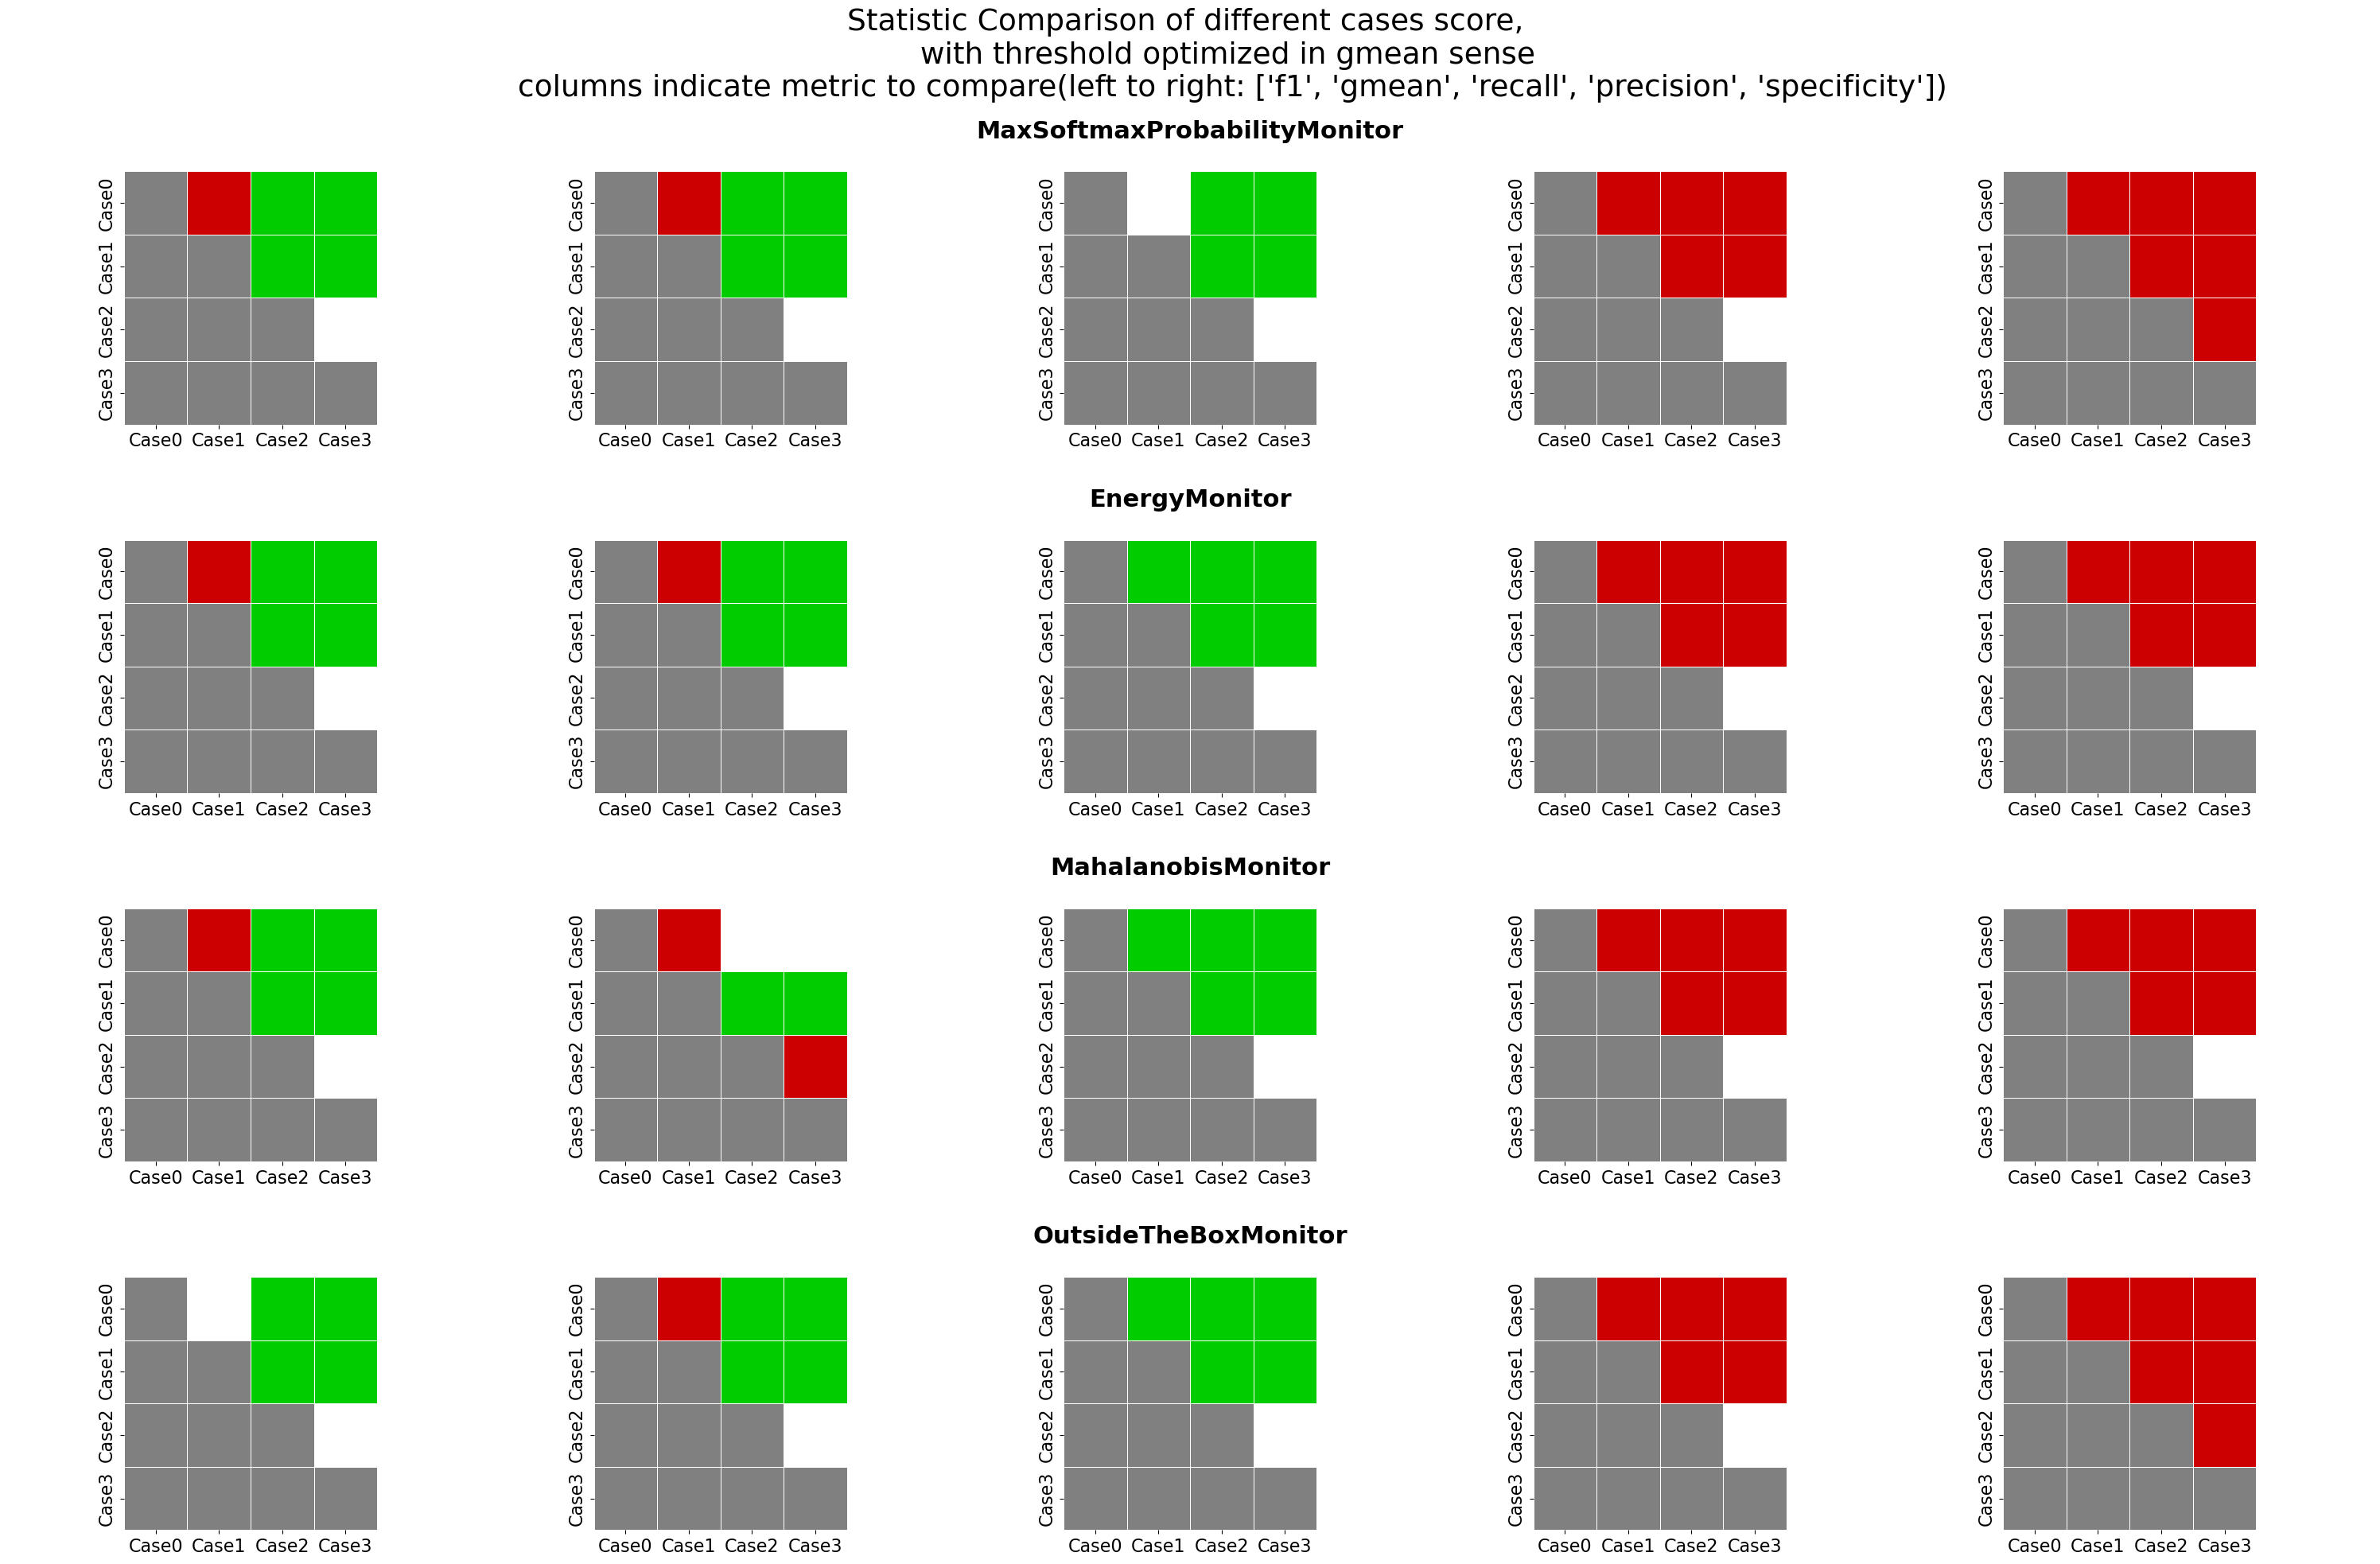

In [9]:
monitor_concerned_list = ['MaxSoftmaxProbabilityMonitor', 'EnergyMonitor', 'MahalanobisMonitor', 'OutsideTheBoxMonitor'] # 
app='gmean'
alpha=0.05 # statistical test level at 5%
metrics_compare = ['f1', 'gmean', 'recall', 'precision', 'specificity']
metrics_compare_colname = ["f1-score_evaluation",  "gmean_evaluation", 
                           'recall-score_evaluation', 'precision-score_evaluation', 'specificity-score_evaluation']
assert len(metrics_compare) == len(metrics_compare_colname)

f, axes = plt.subplots(len(monitor_concerned_list), len(metrics_compare_colname))
plt.rcParams["figure.figsize"] = [30, 20]
f.suptitle(f'Statistic Comparison of different cases score, \n \
        with threshold optimized in {app} sense \n \
        columns indicate metric to compare(left to right: {metrics_compare})',fontsize=27)

case_permute = [0, 1, 3, 2]
real_case_name = ["No Threat (NT)", 'Known Threat (OT)', 'Other Threats (OT)', 'KT + OT']


for no_monitor, monitor_concerned in enumerate(monitor_concerned_list):
    result_to_compare = results_df_all[results_df_all["Monitor"].isin([monitor_concerned])]
    result_to_compare_app = result_to_compare[result_to_compare['Optimal approach']==app]
    
    # Iter over monitor approaches chosen
    for no_metric, col in enumerate(metrics_compare_colname):
        res_statistic = np.zeros((4, 4))
        res_pvalue = np.zeros((4, 4))
        flag =  np.zeros((4, 4)) # -1 if less, +1 if greater, 0 if equal 
    
        # Compute p_value for different tests involved
        pvalue_list = []
        for i in range(4):
            score_evaluation_vect_fix = result_to_compare_app[result_to_compare_app["Case"]==f'Case{case_permute[i]}'][col].tolist()
            for j in range(4):
                if j==i:
                    continue
                score_evaluation_vect_compare  = result_to_compare_app[result_to_compare_app["Case"]==f'Case{case_permute[j]}'][col].tolist()
    
                # conduct the Wilcoxon-Signed Rank Test to compare if 2 scores come from same or other distributions
                res = wilcoxon(score_evaluation_vect_fix, score_evaluation_vect_compare, alternative='two-sided')
                
                pvalue_list.append(res.pvalue)

                res_statistic[i, j] = res.statistic
                res_pvalue[i, j] = res.pvalue
        
        # Adjust significance level with Bonferroni correction
        reject_H0 = multiple_pariwise_comparison_correction(pvalue_list, method='bonferroni', alpha=alpha)
        
        # Add flag if greater or less
        count=0
        for i in range(4):
            score_evaluation_vect_fix = result_to_compare_app[result_to_compare_app["Case"]==f'Case{case_permute[i]}'][col].tolist()
            for j in range(4):
                if j==i:
                    continue
                score_evaluation_vect_compare  = result_to_compare_app[result_to_compare_app["Case"]==f'Case{case_permute[j]}'][col].tolist()
                if reject_H0[count] == True: #different distribution 
                    
                    avg_rank_group1, avg_rank_group2 = compute_average_ranks(score_evaluation_vect_fix, score_evaluation_vect_compare)
                    if avg_rank_group1 > avg_rank_group2: 
                        flag[i,j] = 1
                    else:
                        flag[i,j] = -1
                        
                count += 1
        
        # Plotting 
        ax = pairwise_comparison_pvalue(res_pvalue, flag, metric_name=col, monitor_concerned=[monitor_concerned], 
                                        ax_plot=axes[no_monitor, no_metric], app=app, annot=False)
        for item in ([axes[no_monitor, no_metric].title, axes[no_monitor, no_metric].xaxis.label, axes[no_monitor, no_metric].yaxis.label] +
                     axes[no_monitor, no_metric].get_xticklabels() + axes[no_monitor, no_metric].get_yticklabels()):
            item.set_fontsize('16')
             
# Add title of each row (each monitor)               
grid = plt.GridSpec(len(monitor_concerned_list), len(metrics_compare_colname))
for i in range(len(monitor_concerned_list)):
    create_subtitle(f, grid[i, ::], f'{monitor_concerned_list[i]}', y_posi=1, fontweight='semibold', fontsize=22)

plt.tight_layout(pad=1)
plt.show()

Below we combines scores on evaluation set of all 4 monitors above, and use Wilcoxon signed ranks test to observe difference between cases in a more general view.

In [10]:
novelty_type = ['novelty_cifar10', 'novelty_cifar100', 'novelty_lsun', 'novelty_svhn', 'novelty_tiny_imagenet']
covshift_type = ["brightness", "blur", "pixelization"]
attack_type = ["fgsm", "deepfool", "pgd"]

def plot_compare_casebycase(results_df_all, monitor_concerned, ood_type='all', app='gmean', alpha=0.05):

    result_to_compare = results_df_all[results_df_all["Monitor"].isin(monitor_concerned)]
    if not ood_type == 'all':
        result_to_compare = result_to_compare[result_to_compare['OOD Type'].isin(ood_type)]


    metrics_compare = ['f1', 'gmean', 'recall', 'precision', 'specificity']
    metrics_compare_colname = ["f1-score_evaluation",  "gmean_evaluation", 
                               'recall-score_evaluation', 'precision-score_evaluation', 'specificity-score_evaluation']

    assert len(metrics_compare) == len(metrics_compare_colname)

    f, axes = plt.subplots(1, len(metrics_compare_colname))
    f.suptitle(f'Statistic Comparison of different cases score, \n \
            with threshold optimized in {app} sense \n \
            main OOD type taken : {ood_type} \n \
            monitor method taken: {monitor_concerned} \n \
            columns indicate metric to compare(left to right: {metrics_compare})', y=0.7, fontsize=14.)
    plt.rcParams["figure.figsize"] = [15, 12]

    result_to_compare_app = result_to_compare[result_to_compare['Optimal approach']==app]

    for no_metric, col in enumerate(metrics_compare_colname):

        res_statistic = np.zeros((4, 4))
        res_pvalue = np.zeros((4, 4))
        flag =  np.zeros((4, 4)) # -1 if less, +1 if greater, 0 if equal 

        # Compute p_value for different tests involved
        pvalue_list = []
        for i in range(4):
            score_evaluation_vect_fix = result_to_compare_app[result_to_compare_app["Case"]==f'Case{i}'][col].tolist()
            for j in range(4):
                if j==i:
                    continue
                score_evaluation_vect_compare  = result_to_compare_app[result_to_compare_app["Case"]==f'Case{j}'][col].tolist()
    
                # conduct the Wilcoxon-Signed Rank Test to compare if 2 scores come from same or other distributions
                res = wilcoxon(score_evaluation_vect_fix, score_evaluation_vect_compare, alternative='two-sided')
                
                pvalue_list.append(res.pvalue)

                res_statistic[i, j] = res.statistic
                res_pvalue[i, j] = res.pvalue
        
        # Adjust significance level with Bonferroni correction
        reject_H0 = multiple_pariwise_comparison_correction(pvalue_list, method='bonferroni', alpha=alpha)
        
        # Add flag if greater or less
        count=0
        for i in range(4):
            score_evaluation_vect_fix = result_to_compare_app[result_to_compare_app["Case"]==f'Case{i}'][col].tolist()
            for j in range(4):
                if j==i:
                    continue
                score_evaluation_vect_compare  = result_to_compare_app[result_to_compare_app["Case"]==f'Case{j}'][col].tolist()
                if reject_H0[count] == True: #different distribution 
                    
                    avg_rank_group1, avg_rank_group2 = compute_average_ranks(score_evaluation_vect_fix, score_evaluation_vect_compare)
                    if avg_rank_group1 > avg_rank_group2: 
                        flag[i,j] = 1
                    else:
                        flag[i,j] = -1
                        
                count += 1

        ax = pairwise_comparison_pvalue(res_pvalue, flag, metric_name=col, monitor_concerned=[], 
                                        ax_plot=axes[no_metric], app=app, annot=False, heatmap_title_display=True)
        for item in ([axes[no_metric].title, axes[no_metric].xaxis.label, axes[no_metric].yaxis.label] +
                     axes[no_metric].get_xticklabels() + axes[no_metric].get_yticklabels()):
            item.set_fontsize('12')
    plt.tight_layout()

    return f

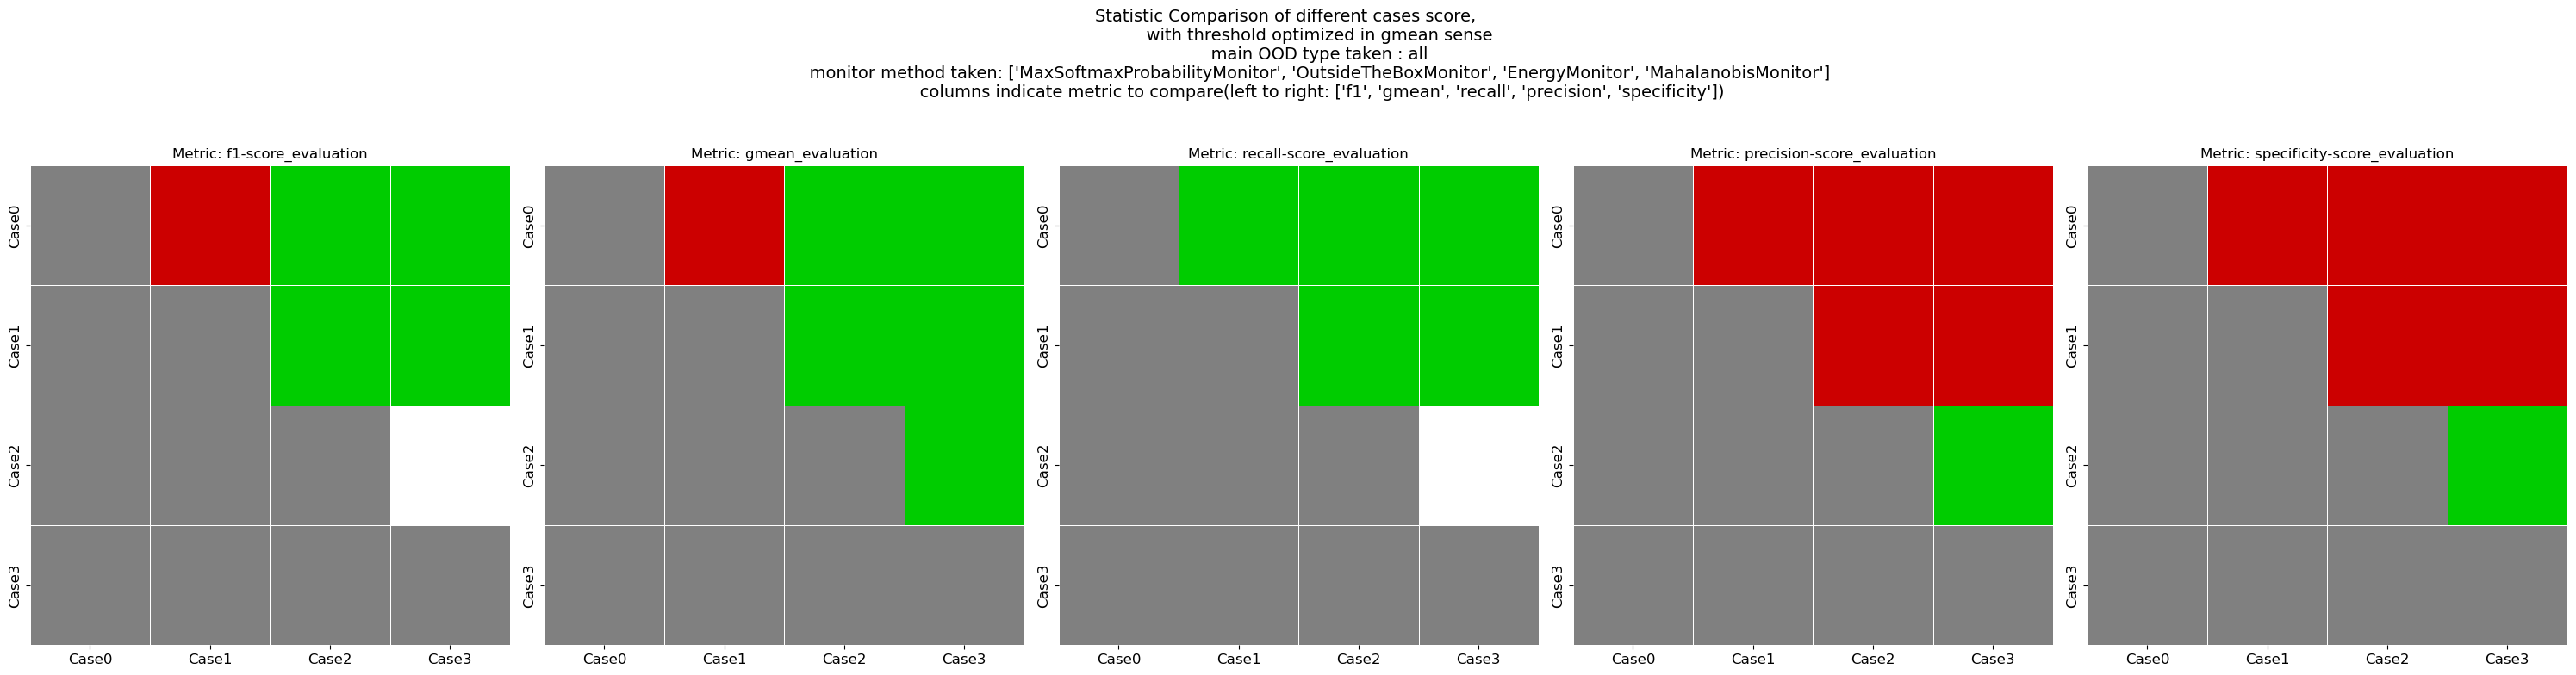

In [11]:
monitor_concerned = ['MaxSoftmaxProbabilityMonitor','OutsideTheBoxMonitor', 'EnergyMonitor', 'MahalanobisMonitor'] # 
f = plot_compare_casebycase(results_df_all, monitor_concerned, ood_type='all', app='gmean')
plt.show()

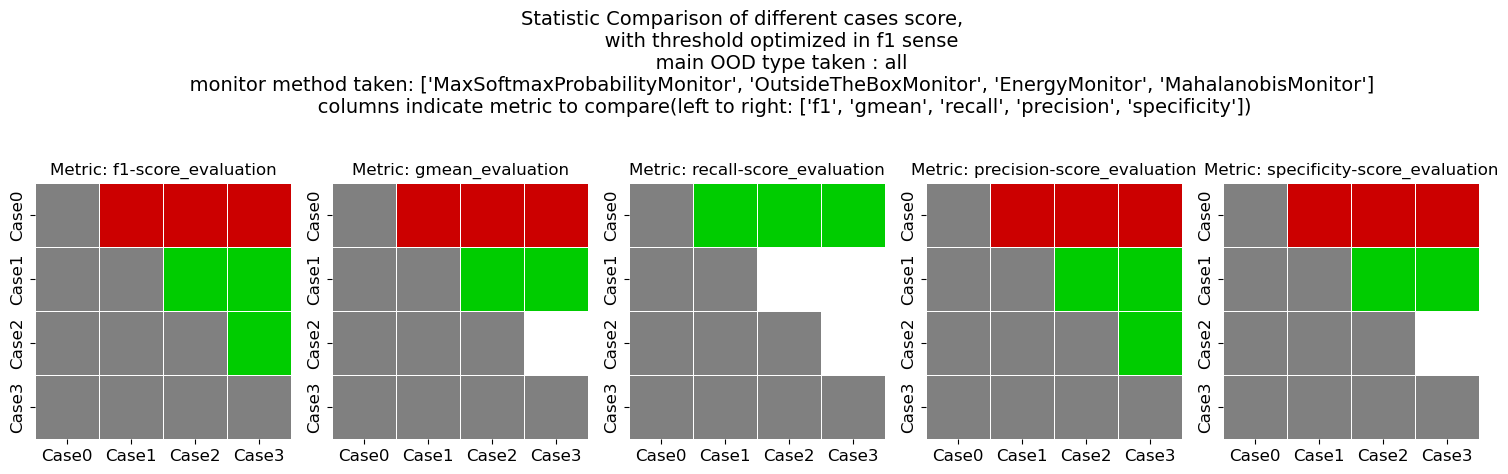

In [12]:
monitor_concerned = ['MaxSoftmaxProbabilityMonitor','OutsideTheBoxMonitor', 'EnergyMonitor', 'MahalanobisMonitor'] # 
f = plot_compare_casebycase(results_df_all, monitor_concerned, ood_type='all', app='f1')
plt.show()

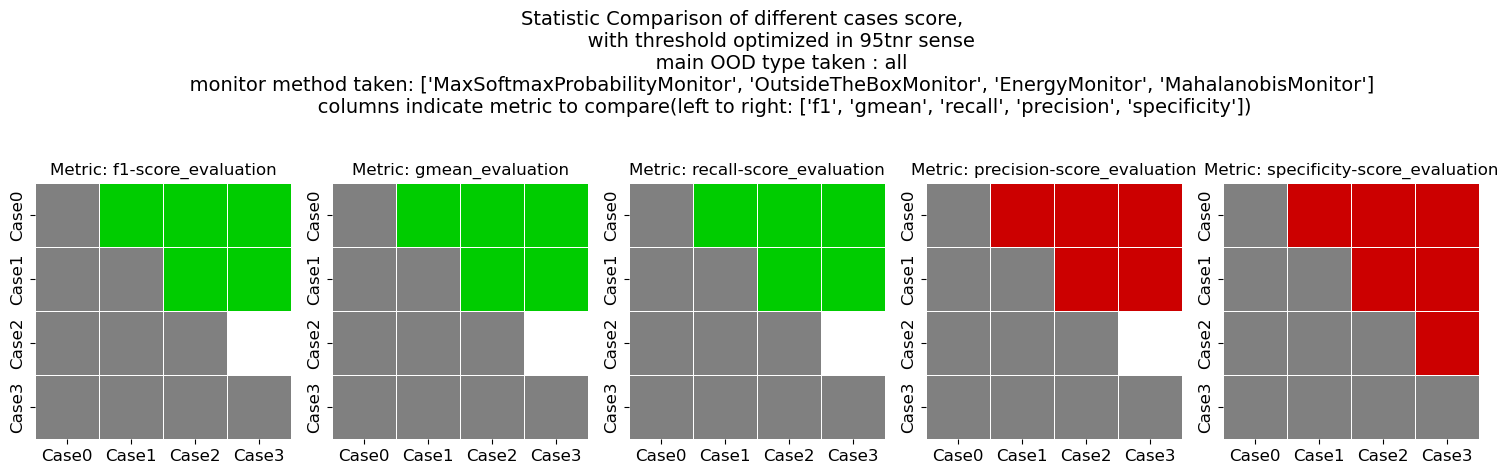

In [13]:
monitor_concerned = ['MaxSoftmaxProbabilityMonitor','OutsideTheBoxMonitor', 'EnergyMonitor', 'MahalanobisMonitor'] # 
f = plot_compare_casebycase(results_df_all, monitor_concerned, ood_type='all', app='95tnr')
plt.show()

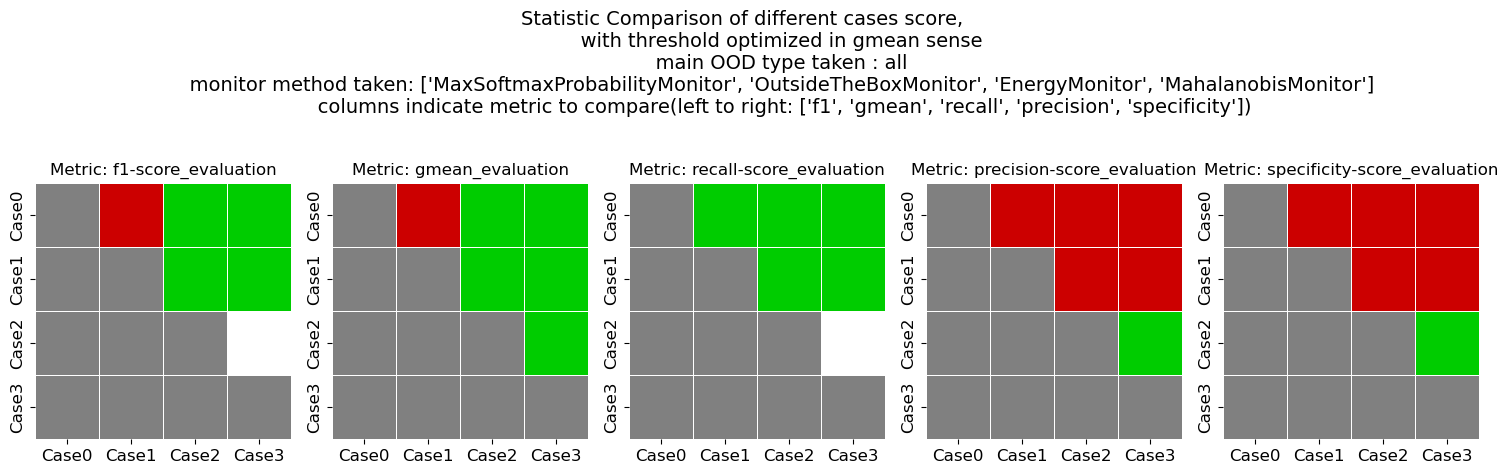

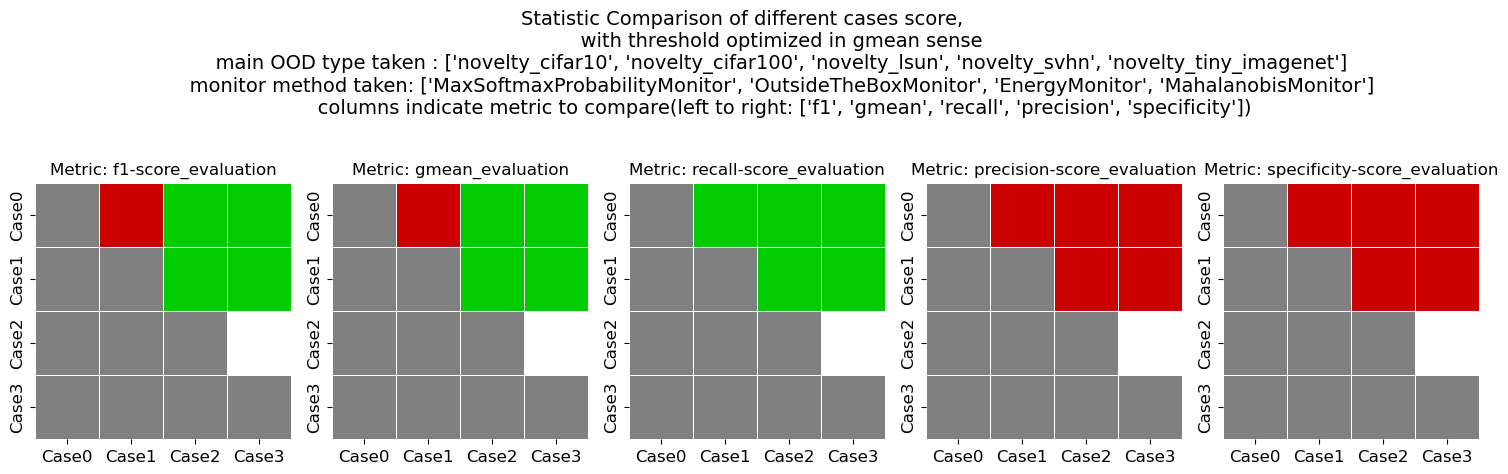

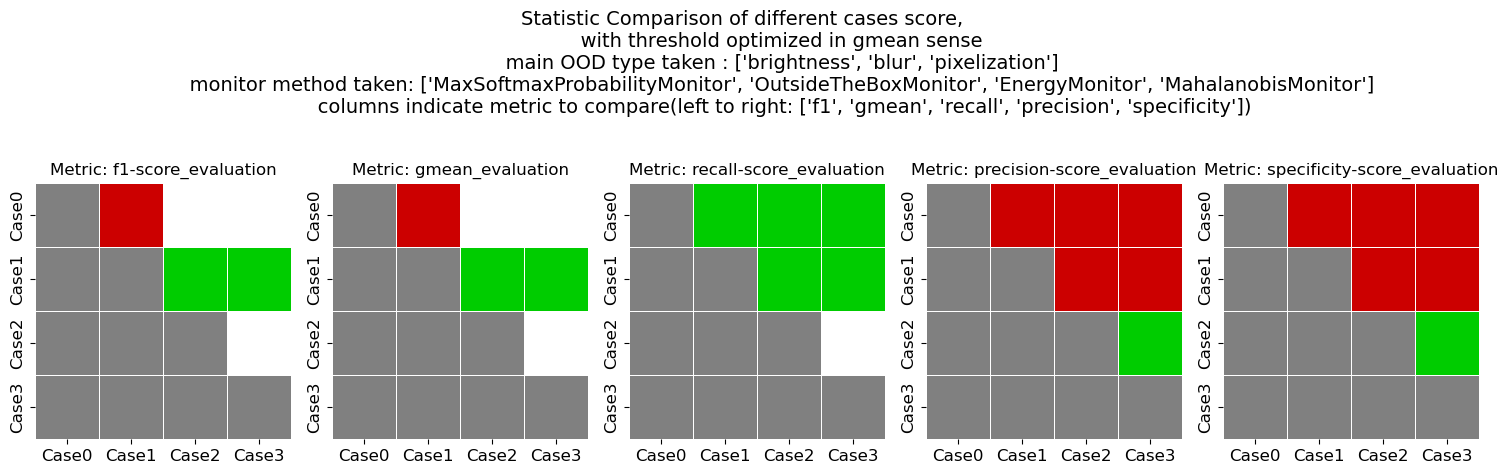

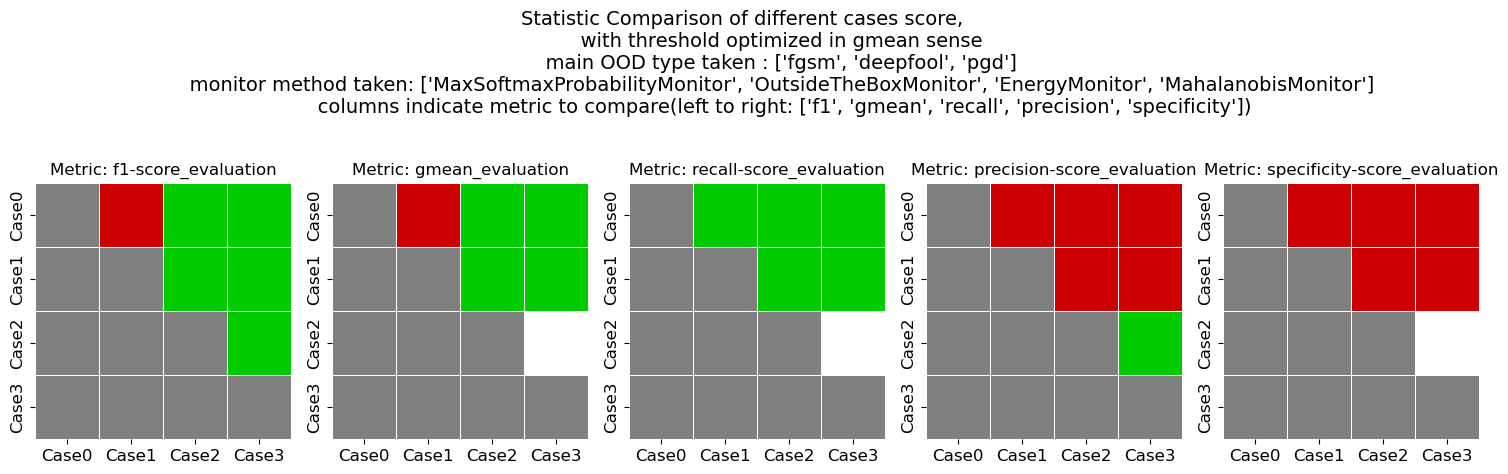

In [14]:
monitor_concerned = ['MaxSoftmaxProbabilityMonitor','OutsideTheBoxMonitor', 'EnergyMonitor', 'MahalanobisMonitor']
app='gmean'
plot_compare_casebycase(results_df_all, monitor_concerned, ood_type='all', app=app) 
plt.show()
plot_compare_casebycase(results_df_all, monitor_concerned, ood_type=novelty_type, app=app)
plt.show()
plot_compare_casebycase(results_df_all, monitor_concerned, ood_type=covshift_type, app=app)
plt.show()
plot_compare_casebycase(results_df_all, monitor_concerned, ood_type=attack_type, app=app)
plt.show()

From this first effort, we see that: the diference between cases if we include main OOD of all possible type (novelty, cov shift or adv attack) is pretty the same if we take only novelty, or only cov shift or adv attack as the main OOD.

To note that, the remaining 8 OOD are always in the threshold optimization set case 2 and 3.



We try below to see if in general the logits-based monitor behaves the same as the distance-based monitor like OTB and Mahalanobis monitor.

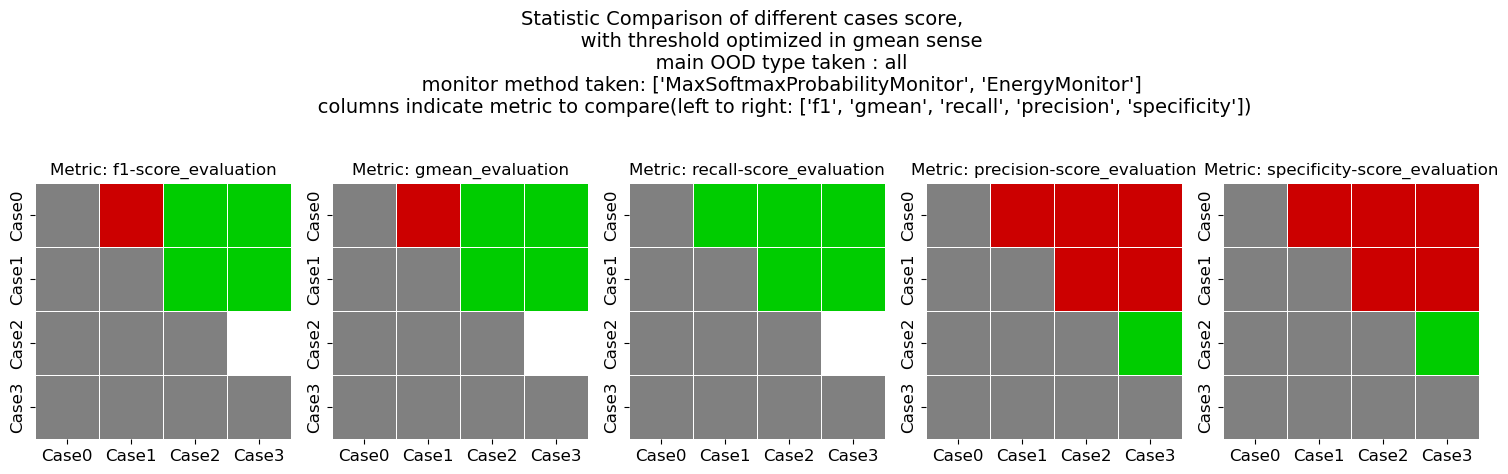

In [15]:
monitor_concerned = ['MaxSoftmaxProbabilityMonitor', 'EnergyMonitor']
app='gmean'
plot_compare_casebycase(results_df_all, monitor_concerned, ood_type='all', app=app) 
plt.show()

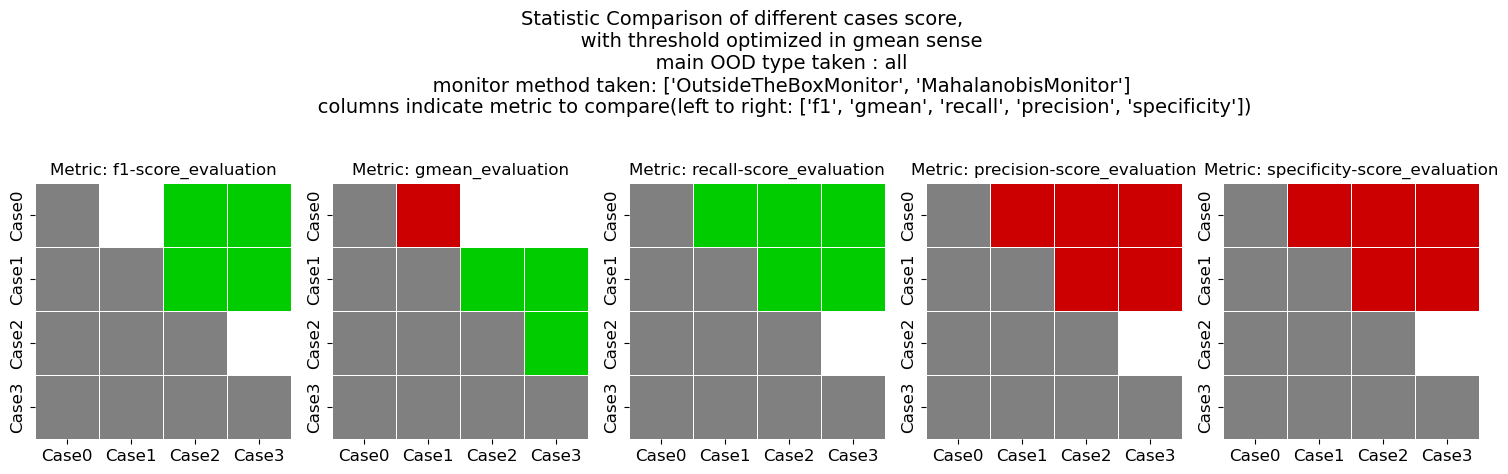

In [16]:
monitor_concerned = ['OutsideTheBoxMonitor', 'MahalanobisMonitor']
app='gmean'
plot_compare_casebycase(results_df_all, monitor_concerned, ood_type='all', app=app) 
plt.show()

### Data Exploration 

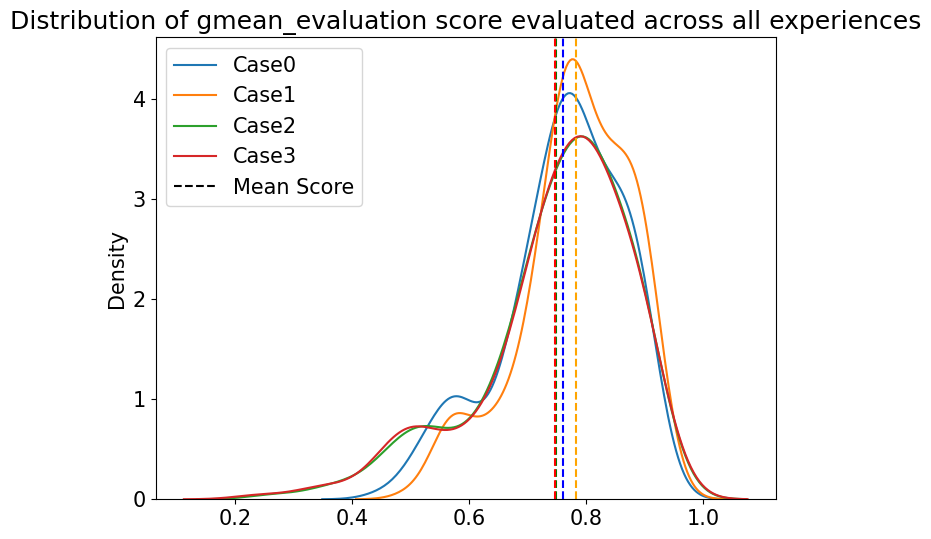

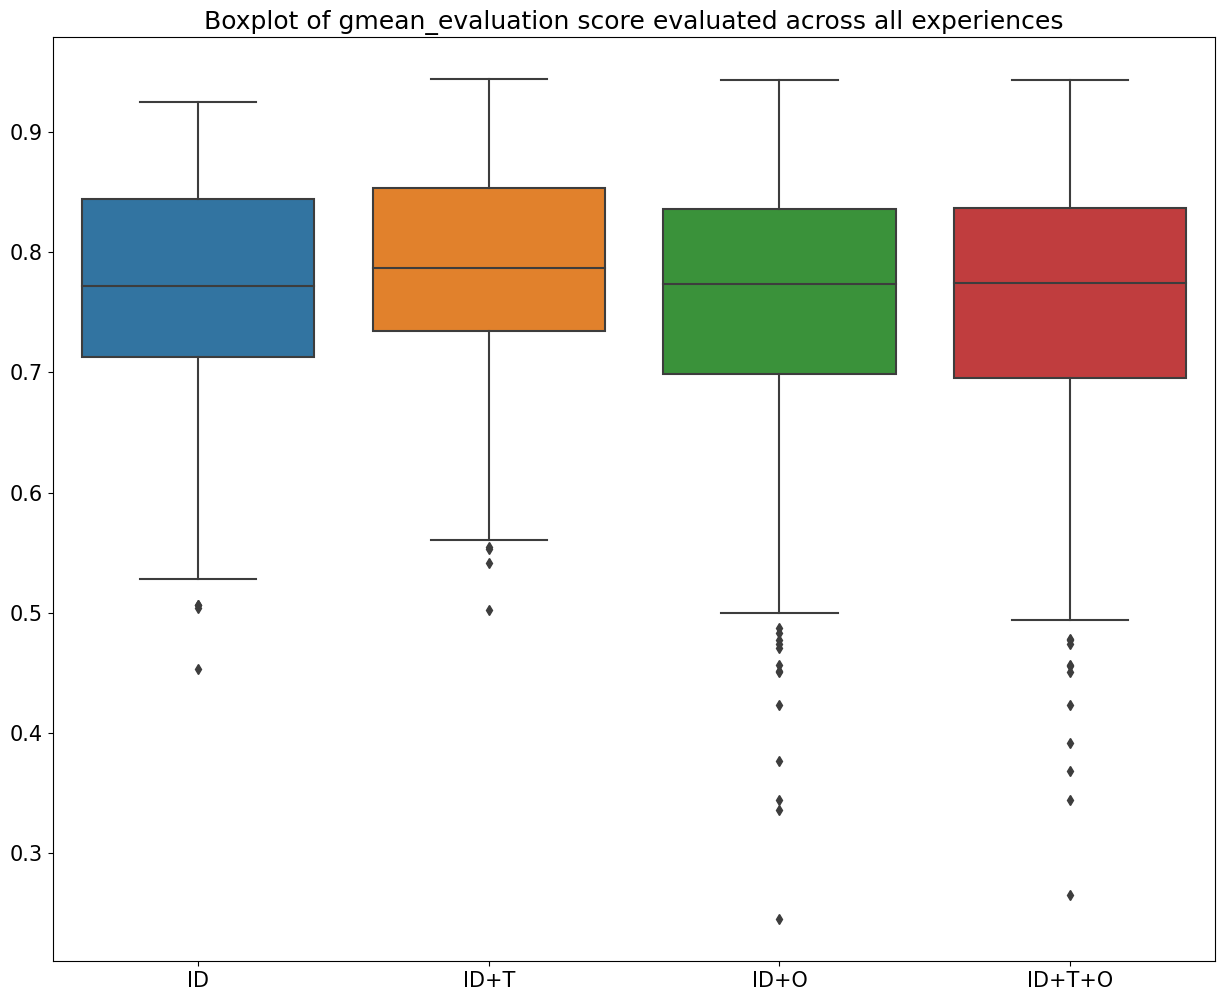

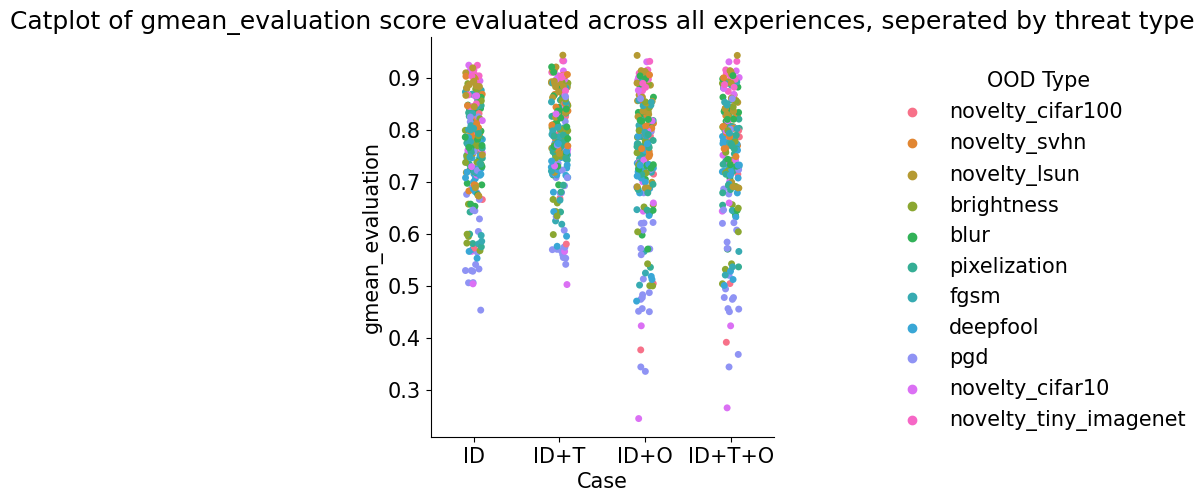

In [17]:
results_df_all = pd.read_csv(path_csv_results + 'Result-Thresh-Opt.csv')

plt.figure(figsize=(8,6))
plt.rcParams.update({'font.size': 15})

metrics_compare_colname = ["f1-score_evaluation",  "gmean_evaluation", 
                           'recall-score_evaluation', 'precision-score_evaluation', 'specificity-score_evaluation']

idx_metric = 1 # 0 for f1 evaluated and 1 for gmean evaluated
name_metric = metrics_compare_colname[idx_metric].split('-')[0]

app='gmean'
results_used = results_df_all[results_df_all['Optimal approach']==app]

monitor_concerned_list = ['MaxSoftmaxProbabilityMonitor','OutsideTheBoxMonitor', 'EnergyMonitor', 'MahalanobisMonitor']
results_used = results_used[results_used['Monitor'].isin(monitor_concerned_list)]


# Distribution of evaluation metric (either f1 or gmean) across all experiences
score_case_0 = np.array(results_used[results_used.Case==f'Case0'][metrics_compare_colname[idx_metric]])
score_case_1 = np.array(results_used[results_used.Case==f'Case1'][metrics_compare_colname[idx_metric]])
score_case_2 = np.array(results_used[results_used.Case==f'Case2'][metrics_compare_colname[idx_metric]])
score_case_3 = np.array(results_used[results_used.Case==f'Case3'][metrics_compare_colname[idx_metric]])

sns.kdeplot(score_case_0 ,label=f'Case0')
sns.kdeplot(score_case_1 ,label=f'Case1')
sns.kdeplot(score_case_2 ,label=f'Case2')
sns.kdeplot(score_case_3 ,label=f'Case3')

plt.axvline(np.mean(score_case_0), color='blue', ls='--' )#, label=f'Mean Case{case_i}')
plt.axvline(np.mean(score_case_1), color='orange', ls='--' )#, label=f'Mean Case{case_i}')
plt.axvline(np.mean(score_case_2), color='green', ls='--' )#, label=f'Mean Case{case_i}')
plt.axvline(np.mean(score_case_3), color='red', ls='--' )#, label=f'Mean Case{case_j}')
plt.plot([], [], '--', color='black', label="Mean Score")

plt.legend()
plt.title(f'Distribution of {name_metric} score evaluated across all experiences')
plt.show()

# Boxplot of evaluation metric (either f1 or gmean) across all experiences
sns.boxplot([score_case_0, score_case_1, score_case_3, score_case_2])
plt.xticks(np.arange(4), ['ID', 'ID+T', 'ID+O', 'ID+T+O'], rotation=0)
plt.title(f'Boxplot of {name_metric} score evaluated across all experiences')
plt.show()

# Catplot of evaluation metric (either f1 or gmean) across all experiences, seperated by threat type'
ax = sns.catplot(data=results_used, x='Case', y=metrics_compare_colname[idx_metric], hue = 'OOD Type', 
                order=['Case0', 'Case1', 'Case3', 'Case2'])
ax.set_xticklabels(['ID', 'ID+T', 'ID+O', 'ID+T+O']) # not set_label(['ID', 'ID+T', 'ID+T+O', 'ID+O'])
plt.title(f'Catplot of {name_metric} score evaluated across all experiences, seperated by threat type')
plt.show()

Here we want to analyze generally by boxplots, the difference of evaluated gmean and f1 between strategy ID and strategy ID+T, between strategy ID and ID+O of all experiences, consecutively without and with oversampling applied. The difference of the evaluated metrics of strategy A minus that of strategy B is denoted $\epsilon^{metric}_{A, B}$.

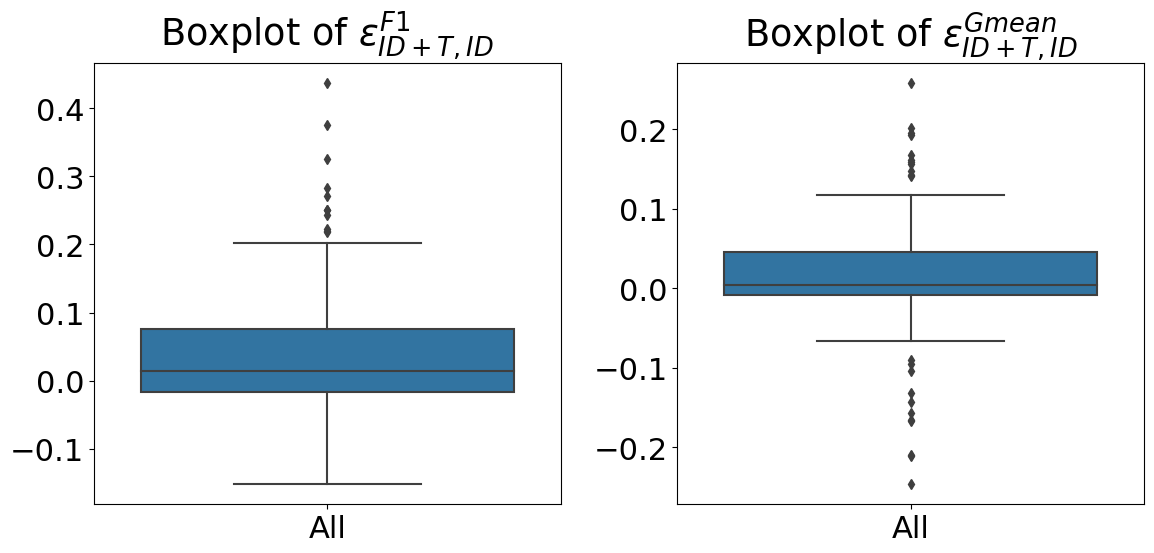

In [18]:
plt.rcParams.update({'font.size': 22})

results_df_all = pd.read_csv(path_csv_results + 'Result-Thresh-Opt.csv')
metrics_compare_colname = ["f1-score_evaluation",  "gmean_evaluation", 
                           'recall-score_evaluation', 'precision-score_evaluation', 'specificity-score_evaluation']
case_i = 0
case_j = 3

app='gmean'
results_used = results_df_all[results_df_all['Optimal approach']==app]

monitor_concerned_list = ['MaxSoftmaxProbabilityMonitor','OutsideTheBoxMonitor', 'EnergyMonitor', 'MahalanobisMonitor']
results_used = results_used[results_used['Monitor'].isin(monitor_concerned_list)]

fig, (ax, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

f1_diff = list(np.array(results_used[results_used.Case==f'Case{case_i}'][metrics_compare_colname[0]])   - np.array(results_used[results_used.Case==f'Case{case_j}'][metrics_compare_colname[0]]))
gmean_diff = list(np.array(results_used[results_used.Case==f'Case{case_i}'][metrics_compare_colname[1]])   - np.array(results_used[results_used.Case==f'Case{case_j}'][metrics_compare_colname[1]]))

sns.boxplot(f1_diff, ax= ax)
ax.set_xticks(np.arange(1), ['All'], rotation=0)
ax.set_title('Boxplot of $\epsilon^{F1}_{ID+T, ID}$')

sns.boxplot(gmean_diff, ax= ax2)
ax2.set_xticks(np.arange(1), ['All'], rotation=0)
ax2.set_title('Boxplot of $\epsilon^{Gmean}_{ID+T, ID}$')

plt.tight_layout()
plt.show()


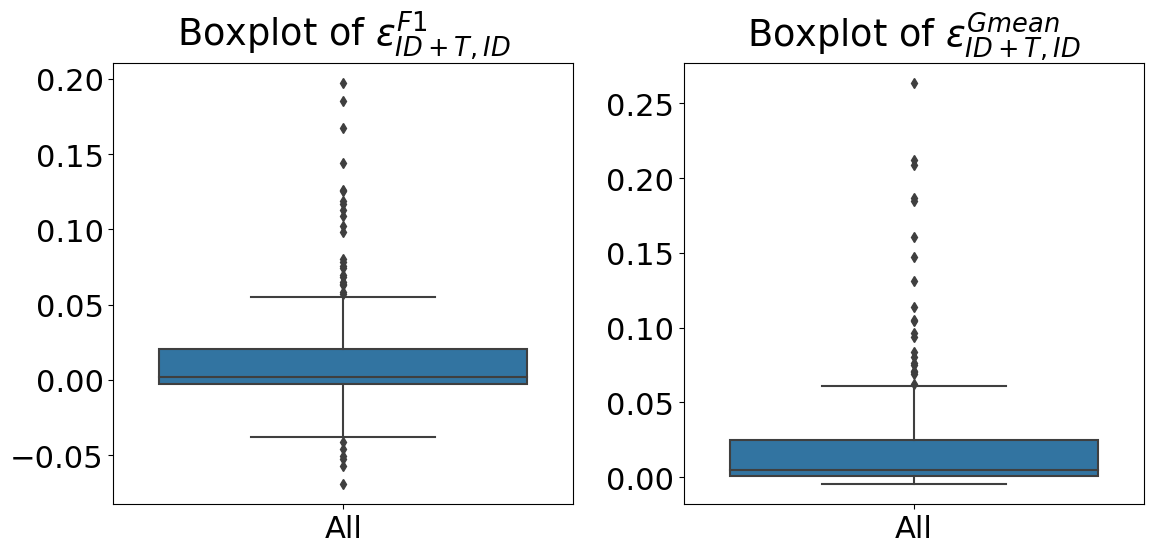

In [19]:
plt.rcParams.update({'font.size': 22})

results_df_all = pd.read_csv(path_csv_results + 'Result-Thresh-Opt.csv')
metrics_compare_colname = ["f1-score_evaluation",  "gmean_evaluation", 
                           'recall-score_evaluation', 'precision-score_evaluation', 'specificity-score_evaluation']
case_i = 1
case_j = 0

app='gmean'
results_used = results_df_all[results_df_all['Optimal approach']==app]

monitor_concerned_list = ['MaxSoftmaxProbabilityMonitor','OutsideTheBoxMonitor', 'EnergyMonitor', 'MahalanobisMonitor']
results_used = results_used[results_used['Monitor'].isin(monitor_concerned_list)]

fig, (ax, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

f1_diff = list(np.array(results_used[results_used.Case==f'Case{case_i}'][metrics_compare_colname[0]])   - np.array(results_used[results_used.Case==f'Case{case_j}'][metrics_compare_colname[0]]))
gmean_diff = list(np.array(results_used[results_used.Case==f'Case{case_i}'][metrics_compare_colname[1]])   - np.array(results_used[results_used.Case==f'Case{case_j}'][metrics_compare_colname[1]]))

sns.boxplot(f1_diff, ax= ax)
ax.set_xticks(np.arange(1), ['All'], rotation=0)
ax.set_title('Boxplot of $\epsilon^{F1}_{ID+T, ID}$')

sns.boxplot(gmean_diff, ax= ax2)
ax2.set_xticks(np.arange(1), ['All'], rotation=0)
ax2.set_title('Boxplot of $\epsilon^{Gmean}_{ID+T, ID}$')

plt.tight_layout()
plt.show()


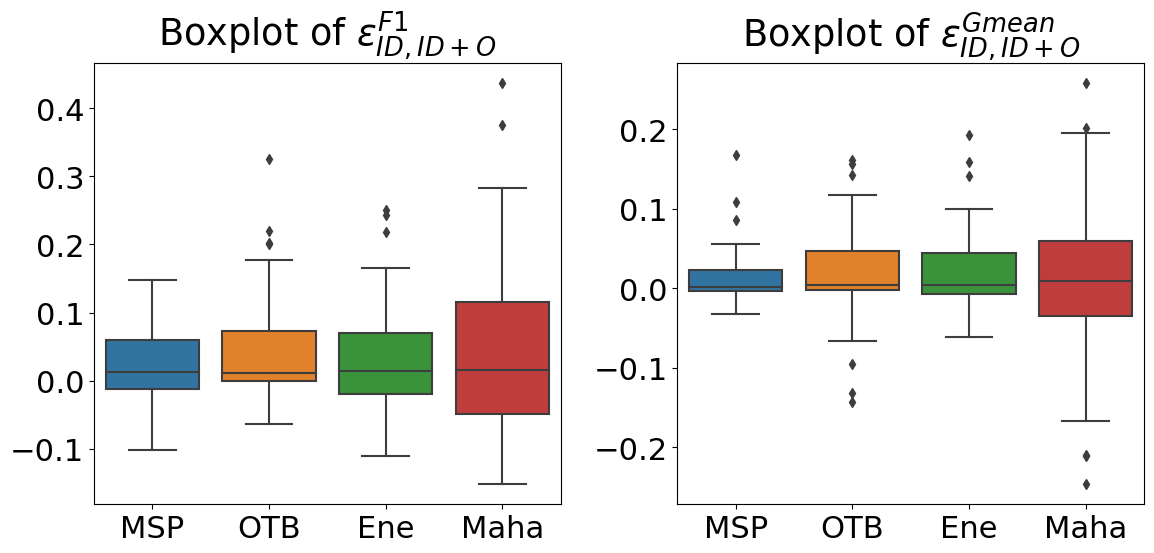

In [20]:
plt.rcParams.update({'font.size': 22})

results_df_all = pd.read_csv(path_csv_results + 'Result-Thresh-Opt.csv')
metrics_compare_colname = ["f1-score_evaluation",  "gmean_evaluation", 
                           'recall-score_evaluation', 'precision-score_evaluation', 'specificity-score_evaluation']
case_i = 0
case_j = 3

app='gmean'
results_used = results_df_all[results_df_all['Optimal approach']==app]

monitor_concerned_list = ['MaxSoftmaxProbabilityMonitor','OutsideTheBoxMonitor', 'EnergyMonitor', 'MahalanobisMonitor']
results_used = results_used[results_used['Monitor'].isin(monitor_concerned_list)]

fig, (ax, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

dict_diff_per_monitor_f1 = {}
dict_diff_per_monitor_gmean = {}

for monitor_name in monitor_concerned_list:
    results_monitor = results_used[results_used['Monitor']==monitor_name]
    dict_diff_per_monitor_f1[monitor_name] = list(np.array(results_monitor[results_monitor.Case==f'Case{case_i}'][metrics_compare_colname[0]])   - np.array(results_monitor[results_monitor.Case==f'Case{case_j}'][metrics_compare_colname[0]]))
    dict_diff_per_monitor_gmean[monitor_name] = list(np.array(results_monitor[results_monitor.Case==f'Case{case_i}'][metrics_compare_colname[1]])   - np.array(results_monitor[results_monitor.Case==f'Case{case_j}'][metrics_compare_colname[1]]))

sns.boxplot(list(dict_diff_per_monitor_f1.values()), ax= ax)
ax.set_xticks(np.arange(4), ['MSP', 'OTB', 'Ene', 'Maha'], rotation=0)
ax.set_title('Boxplot of $\epsilon^{F1}_{ID, ID+O}$')

sns.boxplot(list(dict_diff_per_monitor_gmean.values()), ax= ax2)
ax2.set_xticks(np.arange(4), ['MSP', 'OTB', 'Ene', 'Maha'], rotation=0)
ax2.set_title('Boxplot of $\epsilon^{Gmean}_{ID, ID+O}$')

plt.tight_layout()
plt.show()


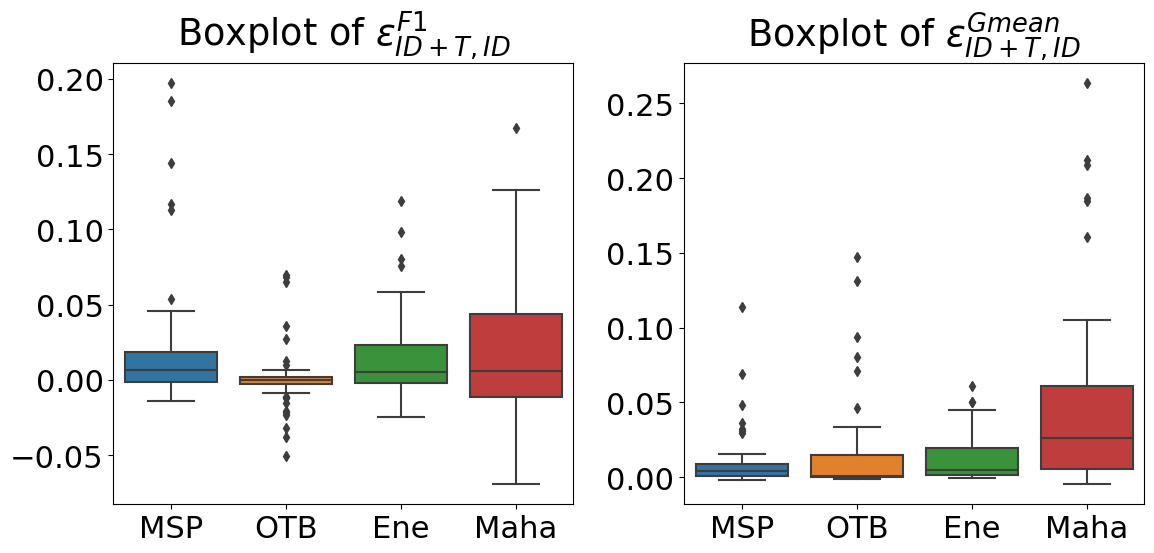

In [21]:
results_df_all = pd.read_csv(path_csv_results + 'Result-Thresh-Opt.csv')
metrics_compare_colname = ["f1-score_evaluation",  "gmean_evaluation", 
                           'recall-score_evaluation', 'precision-score_evaluation', 'specificity-score_evaluation']
case_i = 1
case_j = 0

app='gmean'
results_used = results_df_all[results_df_all['Optimal approach']==app]

monitor_concerned_list = ['MaxSoftmaxProbabilityMonitor','OutsideTheBoxMonitor', 'EnergyMonitor', 'MahalanobisMonitor']
results_used = results_used[results_used['Monitor'].isin(monitor_concerned_list)]

fig, (ax, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

dict_diff_per_monitor_f1 = {}
dict_diff_per_monitor_gmean = {}

for monitor_name in monitor_concerned_list:
    results_monitor = results_used[results_used['Monitor']==monitor_name]
    dict_diff_per_monitor_f1[monitor_name] = list(np.array(results_monitor[results_monitor.Case==f'Case{case_i}'][metrics_compare_colname[0]])   - np.array(results_monitor[results_monitor.Case==f'Case{case_j}'][metrics_compare_colname[0]]))
    dict_diff_per_monitor_gmean[monitor_name] = list(np.array(results_monitor[results_monitor.Case==f'Case{case_i}'][metrics_compare_colname[1]])   - np.array(results_monitor[results_monitor.Case==f'Case{case_j}'][metrics_compare_colname[1]]))

sns.boxplot(list(dict_diff_per_monitor_f1.values()), ax= ax)
ax.set_xticks(np.arange(4), ['MSP', 'OTB', 'Ene', 'Maha'], rotation=0)
ax.set_title('Boxplot of $\epsilon^{F1}_{ID+T, ID}$')

sns.boxplot(list(dict_diff_per_monitor_gmean.values()), ax= ax2)
ax2.set_xticks(np.arange(4), ['MSP', 'OTB', 'Ene', 'Maha'], rotation=0)
ax2.set_title('Boxplot of $\epsilon^{Gmean}_{ID+T, ID}$')

plt.tight_layout()

plt.show()


### Average AUC, AUPR of four cases

In [22]:
results_df_all = pd.read_csv(path_csv_results + 'Result-Thresh-Opt.csv')
results_df_all = results_df_all[results_df_all['Optimal approach']=='gmean']

metrics_compare_colname = ['AUROC-score_optimization', 'AUPR_rejectPosi-score_optimization', 'TPR@95TNR-score_optimization',
                   'AUROC-score_evaluation', 'AUPR_rejecPosi-score_evaluation', 'TPR@95TNR-score_evaluation']

table_rankingmetric_percase = pd.DataFrame(columns=metrics_compare_colname, index=['Case0', 'Case1', 'Case2', 'Case3'])
for metric in metrics_compare_colname: 
    for case in range(4):
        table_rankingmetric_percase.loc[f'Case{case}', metric] = results_df_all[results_df_all.Case == f'Case{case}'][metric].mean().round(2)
        
table_rankingmetric_percase       

,AUROC-score_optimization,AUPR_rejectPosi-score_optimization,TPR@95TNR-score_optimization,AUROC-score_evaluation,AUPR_rejecPosi-score_evaluation,TPR@95TNR-score_evaluation
Case0,0.79,0.35,0.38,0.8,0.7,0.38
Case1,0.8,0.7,0.38,0.8,0.7,0.38
Case2,0.69,0.81,0.15,0.8,0.7,0.38
Case3,0.69,0.81,0.16,0.8,0.7,0.38


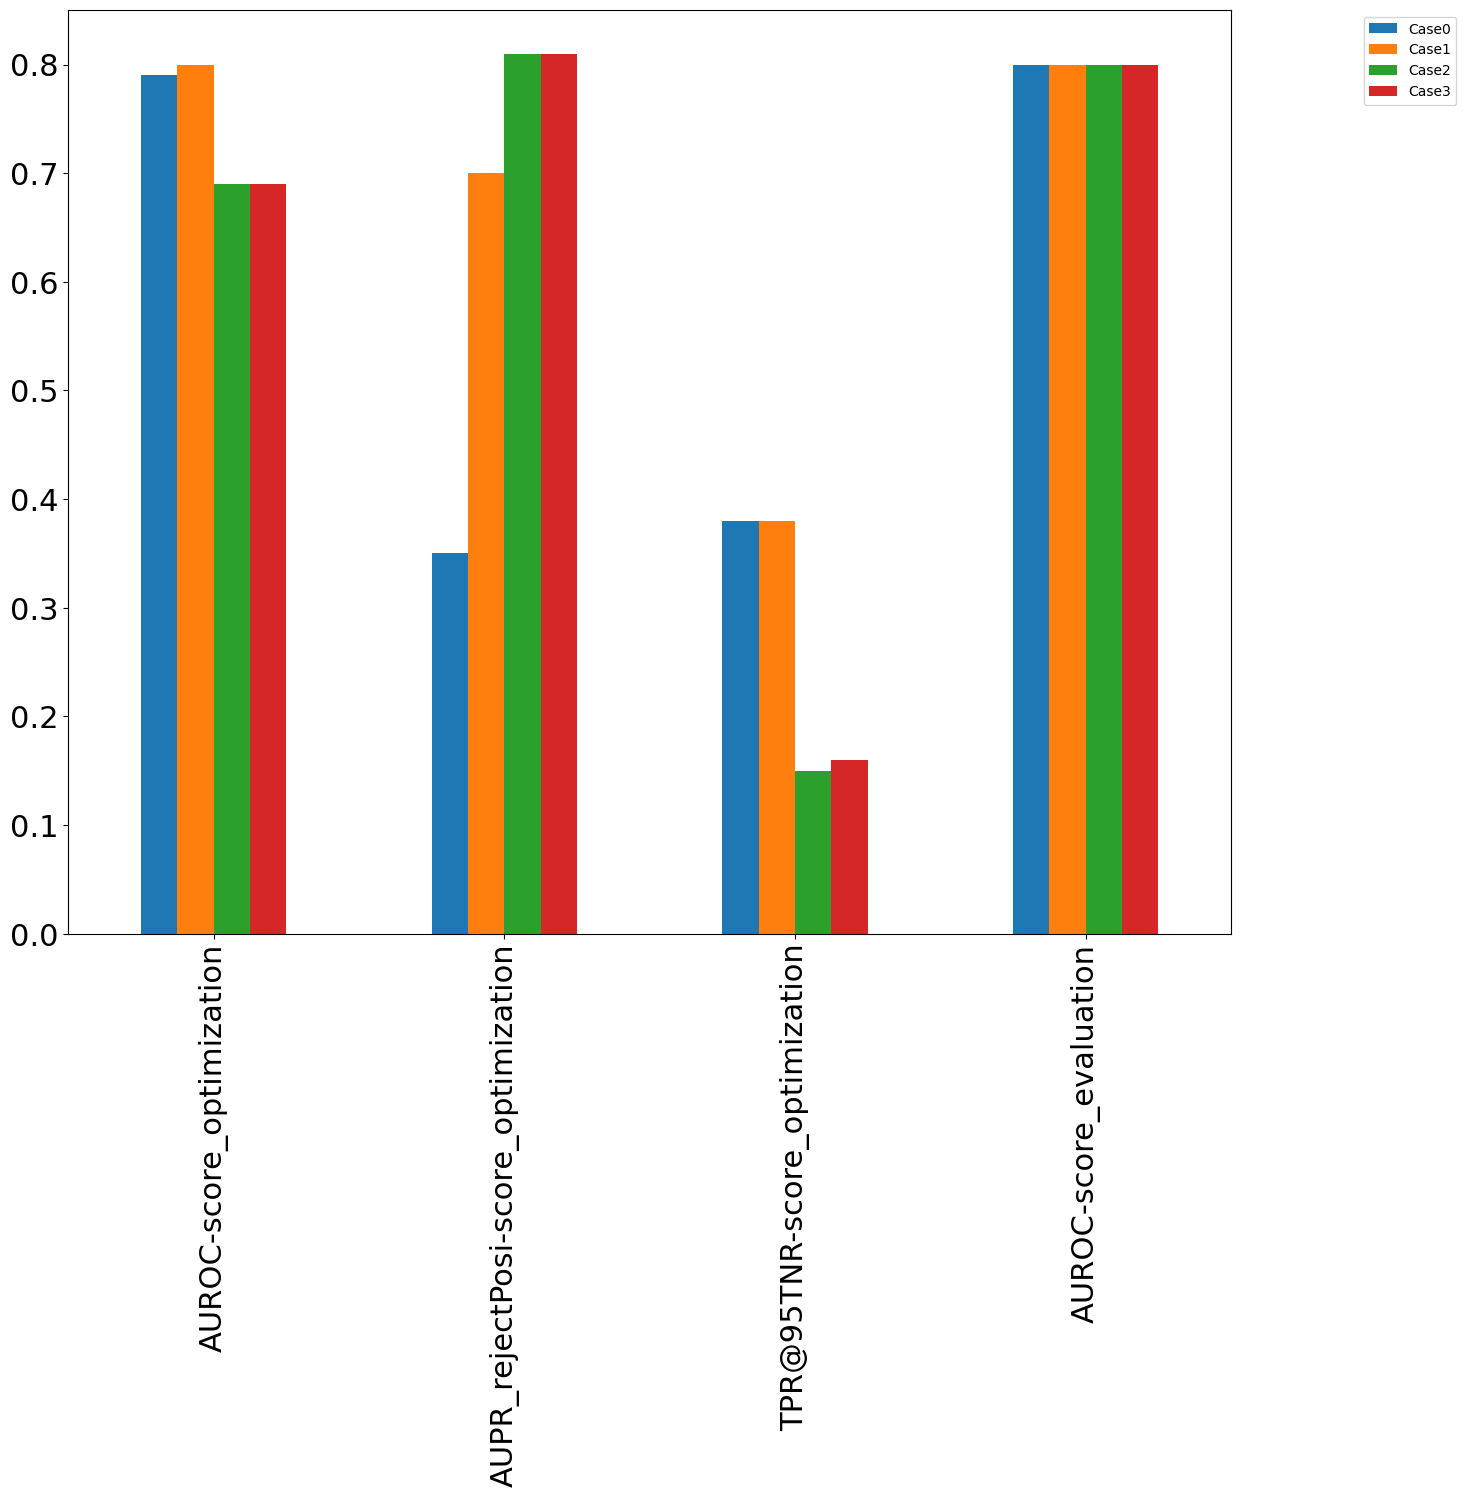

In [23]:
axes = table_rankingmetric_percase.iloc[:, :4].T.plot.bar(rot=90, subplots=False)
axes.legend(bbox_to_anchor= (1.2,1), fontsize=10)


In [24]:
results_df_all = pd.read_csv(path_csv_results + 'Result-Thresh-Opt_resampling.csv')
results_df_all = results_df_all[results_df_all['Optimal approach']=='gmean']

metrics_compare_colname = ['AUROC-score_optimization', 'AUPR_rejectPosi-score_optimization', 'TPR@95TNR-score_optimization',
                   'AUROC-score_evaluation', 'AUPR_rejecPosi-score_evaluation', 'TPR@95TNR-score_evaluation']

table_rankingmetric_percase = pd.DataFrame(columns=metrics_compare_colname, index=['Case0', 'Case1', 'Case2', 'Case3'])
for metric in metrics_compare_colname: 
    for case in range(4):
        table_rankingmetric_percase.loc[f'Case{case}', metric] = results_df_all[results_df_all.Case == f'Case{case}'][metric].mean().round(2)
        
table_rankingmetric_percase       

,AUROC-score_optimization,AUPR_rejectPosi-score_optimization,TPR@95TNR-score_optimization,AUROC-score_evaluation,AUPR_rejecPosi-score_evaluation,TPR@95TNR-score_evaluation
Case0,0.79,0.78,0.38,0.8,0.7,0.38
Case1,0.8,0.78,0.38,0.8,0.7,0.38
Case2,0.69,0.64,0.15,0.8,0.7,0.38
Case3,0.69,0.65,0.16,0.8,0.7,0.38


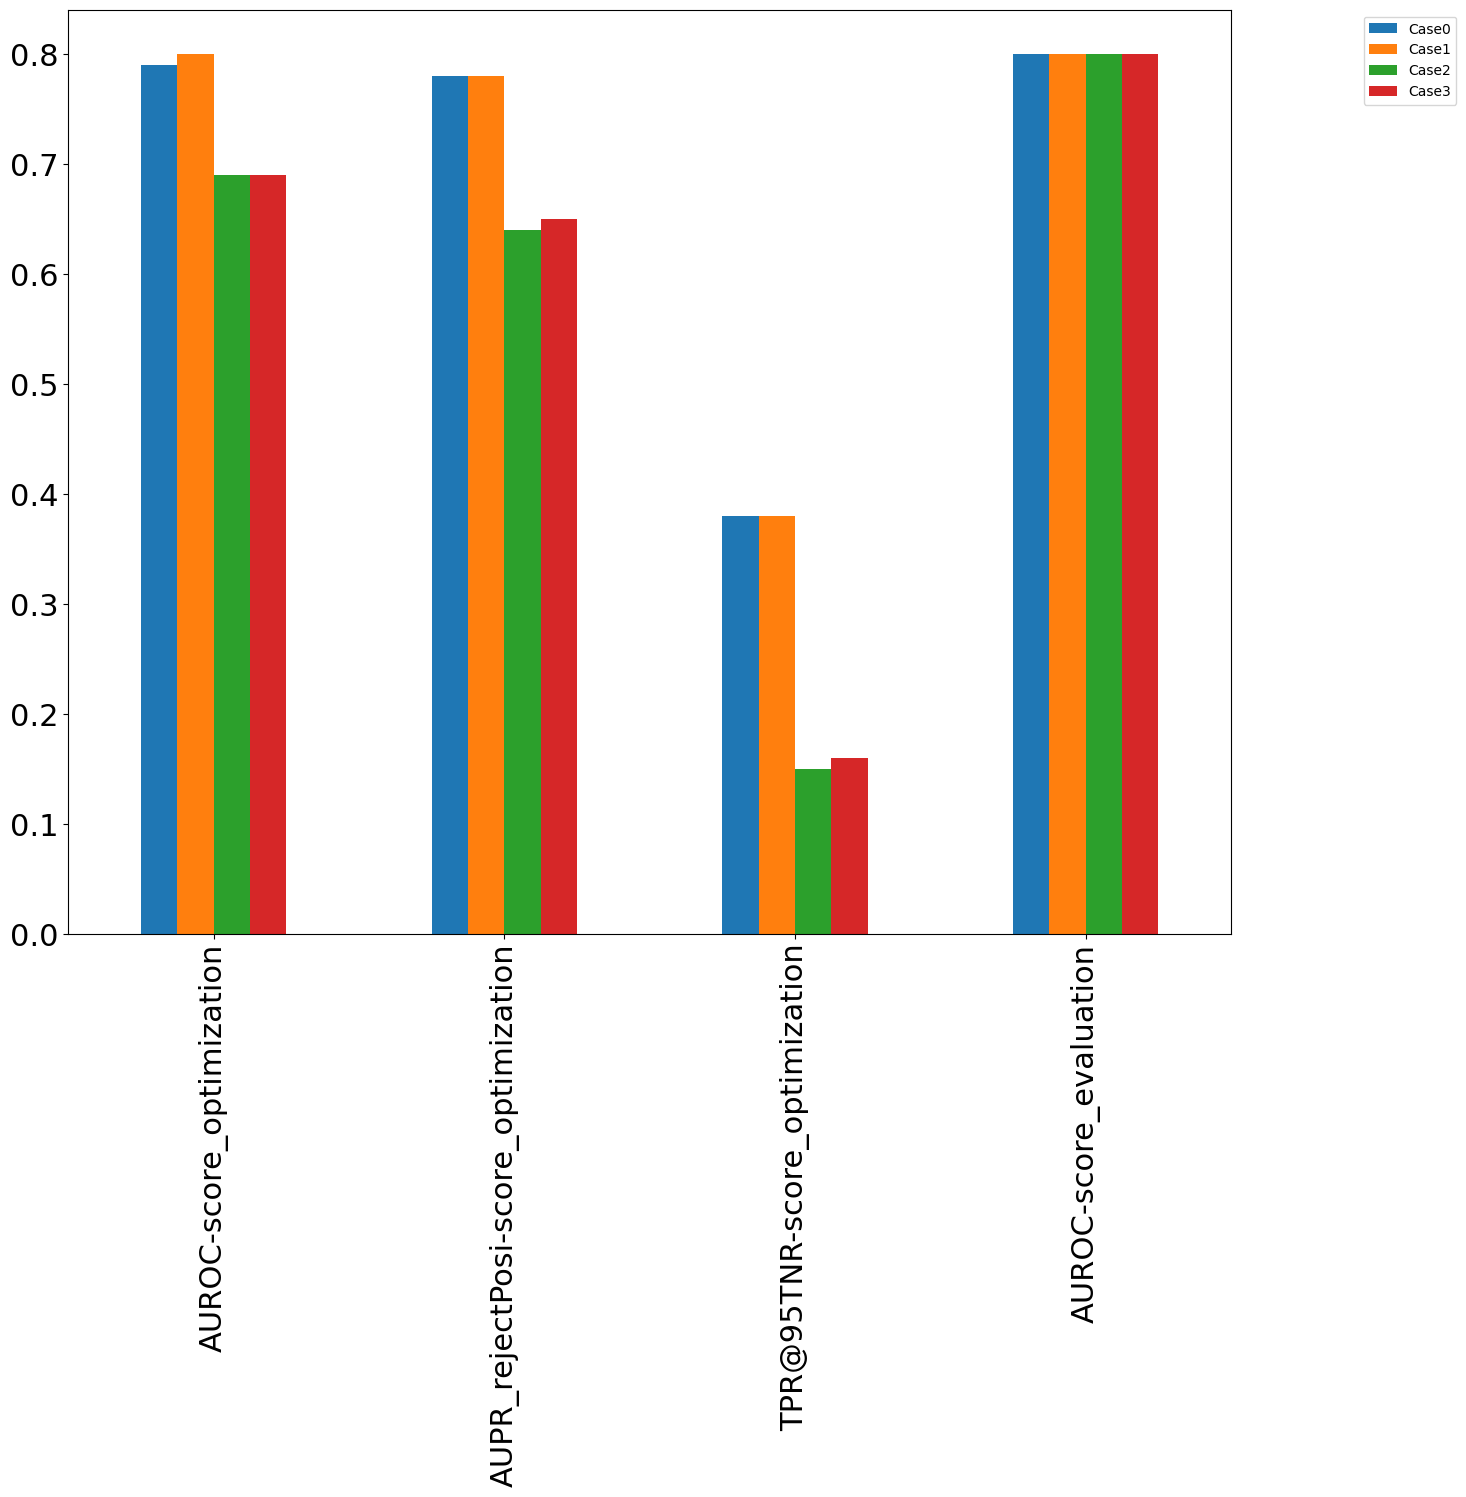

In [25]:
axes = table_rankingmetric_percase.iloc[:, :4].T.plot.bar(rot=90, subplots=False)
axes.legend(bbox_to_anchor= (1.2,1), fontsize=10)


### Average AUC, AUPR of different OOD types 

In [26]:
novelty_type = ['novelty_cifar10', 'novelty_cifar100', 'novelty_lsun', 'novelty_svhn', 'novelty_tiny_imagenet']
covshift_type = ["brightness", "blur", "pixelization"]
attack_type = ["fgsm", "deepfool", "pgd"]

all_odd_type = novelty_type + covshift_type + attack_type

metrics_compare_colname = ['AUROC-score_optimization', 'AUPR_rejectPosi-score_optimization', 'TPR@95TNR-score_optimization',
                   'AUROC-score_evaluation', 'AUPR_rejecPosi-score_evaluation', 'TPR@95TNR-score_evaluation']
table_rankingmetric_perood = pd.DataFrame(columns=metrics_compare_colname, index=all_odd_type)


monitor_concerned_list = ['MaxSoftmaxProbabilityMonitor', 'EnergyMonitor', 'MahalanobisMonitor', 'OutsideTheBoxMonitor'] # 
results_df_all = pd.read_csv(path_csv_results+'Result-Thresh-Opt.csv')
results_df_all = results_df_all[results_df_all['Optimal approach']=='gmean']

results_used = results_df_all[results_df_all["Monitor"].isin(monitor_concerned_list)]
for ood_type in all_odd_type:
    results_ood = results_used[results_used['OOD Type']==(ood_type)]
    for metric in metrics_compare_colname:
        table_rankingmetric_perood.loc[ood_type, metric] = np.round(results_ood[metric].mean(), 2)


table_rankingmetric_perood       

,AUROC-score_optimization,AUPR_rejectPosi-score_optimization,TPR@95TNR-score_optimization,AUROC-score_evaluation,AUPR_rejecPosi-score_evaluation,TPR@95TNR-score_evaluation
novelty_cifar10,0.78,0.72,0.33,0.84,0.84,0.52
novelty_cifar100,0.74,0.7,0.28,0.84,0.84,0.47
novelty_lsun,0.78,0.72,0.35,0.91,0.9,0.66
novelty_svhn,0.74,0.76,0.28,0.9,0.96,0.54
novelty_tiny_imagenet,0.85,0.66,0.47,0.94,0.9,0.83
brightness,0.76,0.68,0.28,0.83,0.68,0.37
blur,0.77,0.68,0.29,0.87,0.71,0.45
pixelization,0.76,0.65,0.27,0.82,0.56,0.34
fgsm,0.76,0.68,0.29,0.85,0.7,0.41
deepfool,0.76,0.66,0.25,0.75,0.57,0.16


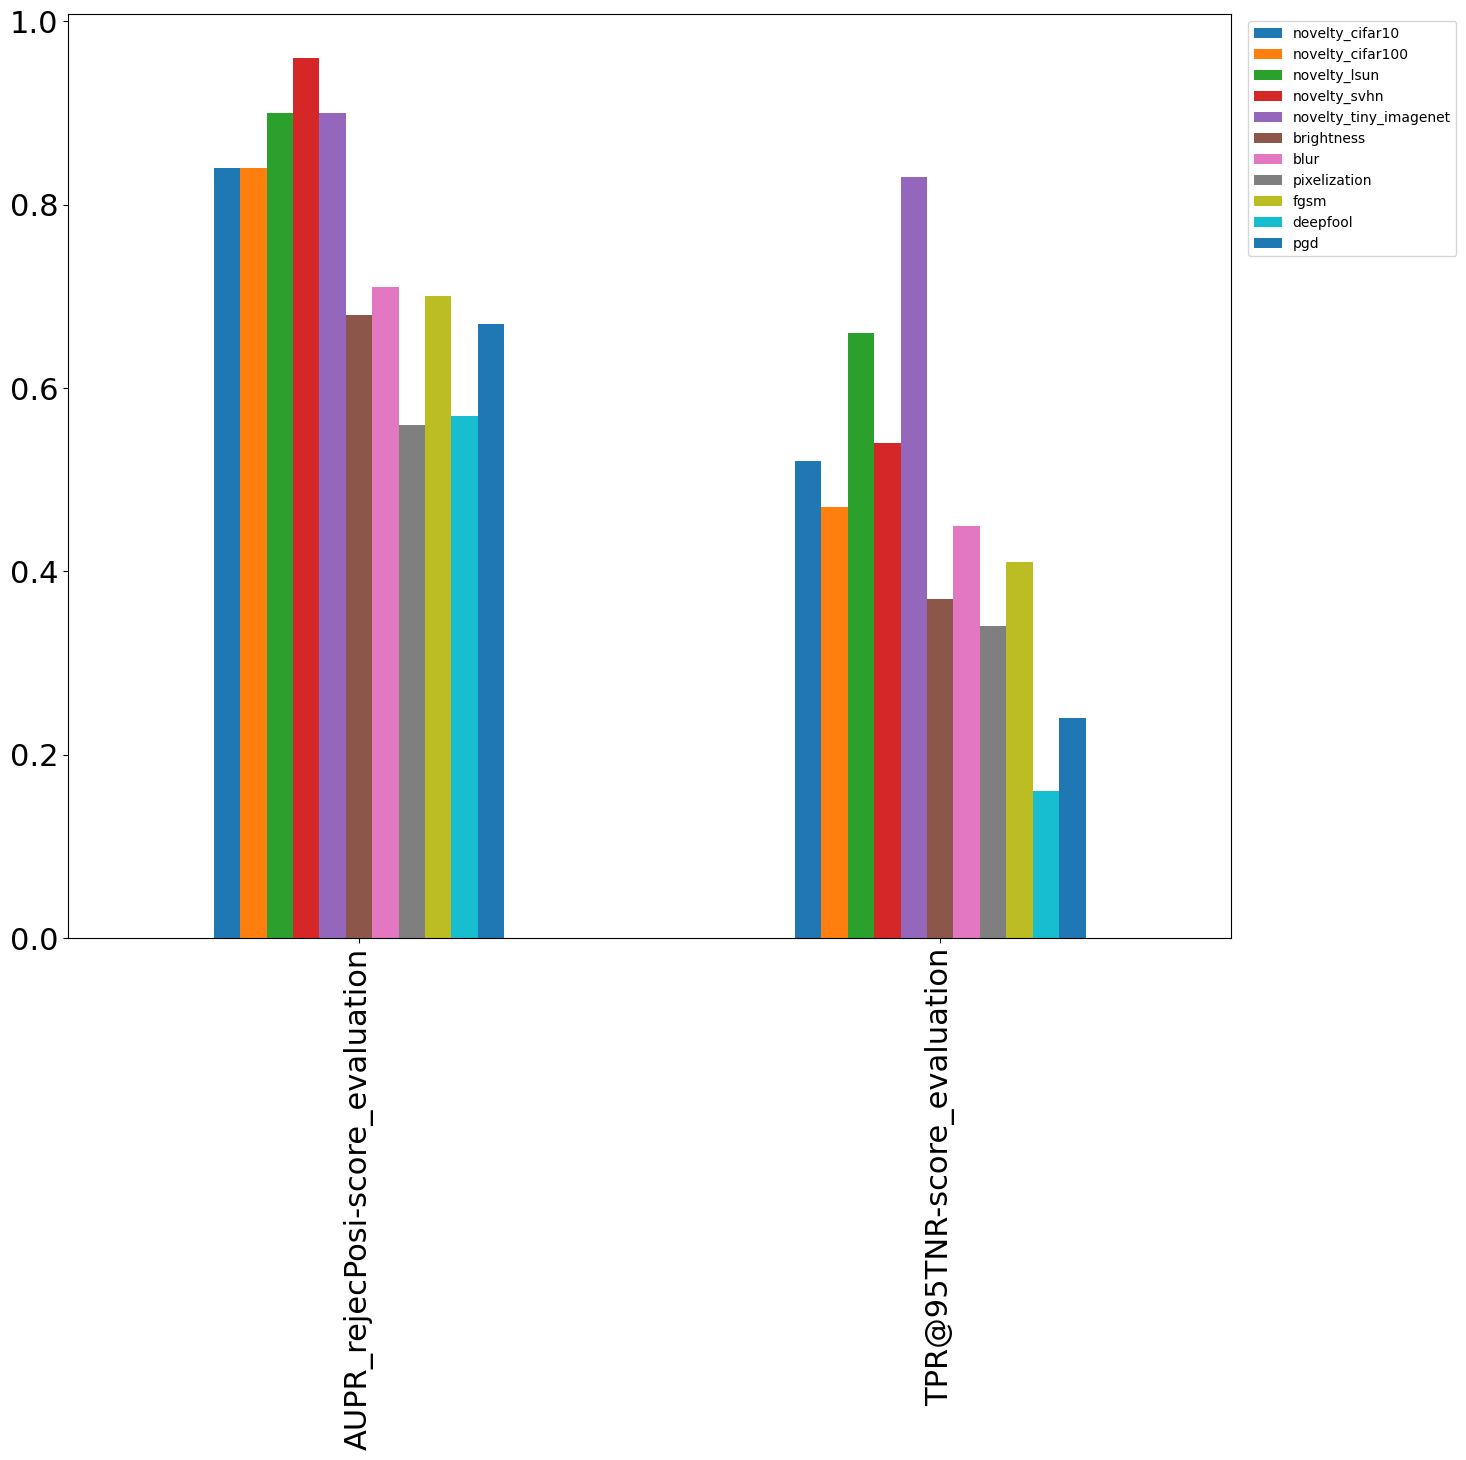

In [27]:
axes = table_rankingmetric_perood.iloc[:, 4:].T.plot.bar(rot=90, subplots=False)
axes.legend(bbox_to_anchor= (1.2,1), fontsize=10)


In [28]:
novelty_type = ['novelty_cifar10', 'novelty_cifar100', 'novelty_lsun', 'novelty_svhn', 'novelty_tiny_imagenet']
covshift_type = ["brightness", "blur", "pixelization"]
attack_type = ["fgsm", "deepfool", "pgd"]

all_odd_type = novelty_type + covshift_type + attack_type

metrics_compare_colname = ['AUROC-score_optimization', 'AUPR_rejectPosi-score_optimization', 'TPR@95TNR-score_optimization',
                   'AUROC-score_evaluation', 'AUPR_rejecPosi-score_evaluation', 'TPR@95TNR-score_evaluation']
table_rankingmetric_perood = pd.DataFrame(columns=metrics_compare_colname, index=all_odd_type)


monitor_concerned_list = ['MaxSoftmaxProbabilityMonitor', 'EnergyMonitor', 'MahalanobisMonitor', 'OutsideTheBoxMonitor'] # 
results_df_all = pd.read_csv(path_csv_results + 'Result-Thresh-Opt_resampling.csv')
results_df_all = results_df_all[results_df_all['Optimal approach']=='gmean']

results_used = results_df_all[results_df_all["Monitor"].isin(monitor_concerned_list)]
for ood_type in all_odd_type:
    results_ood = results_used[results_used['OOD Type']==(ood_type)]
    for metric in metrics_compare_colname:
        table_rankingmetric_perood.loc[ood_type, metric] = np.round(results_ood[metric].mean(), 2)


table_rankingmetric_perood       

,AUROC-score_optimization,AUPR_rejectPosi-score_optimization,TPR@95TNR-score_optimization,AUROC-score_evaluation,AUPR_rejecPosi-score_evaluation,TPR@95TNR-score_evaluation
novelty_cifar10,0.78,0.74,0.33,0.84,0.84,0.52
novelty_cifar100,0.74,0.72,0.28,0.84,0.84,0.47
novelty_lsun,0.78,0.75,0.35,0.91,0.9,0.66
novelty_svhn,0.74,0.72,0.28,0.9,0.96,0.54
novelty_tiny_imagenet,0.85,0.82,0.47,0.94,0.9,0.83
brightness,0.76,0.73,0.28,0.83,0.68,0.37
blur,0.77,0.74,0.29,0.87,0.71,0.46
pixelization,0.76,0.72,0.27,0.82,0.56,0.34
fgsm,0.76,0.73,0.29,0.85,0.7,0.41
deepfool,0.76,0.72,0.25,0.75,0.57,0.16


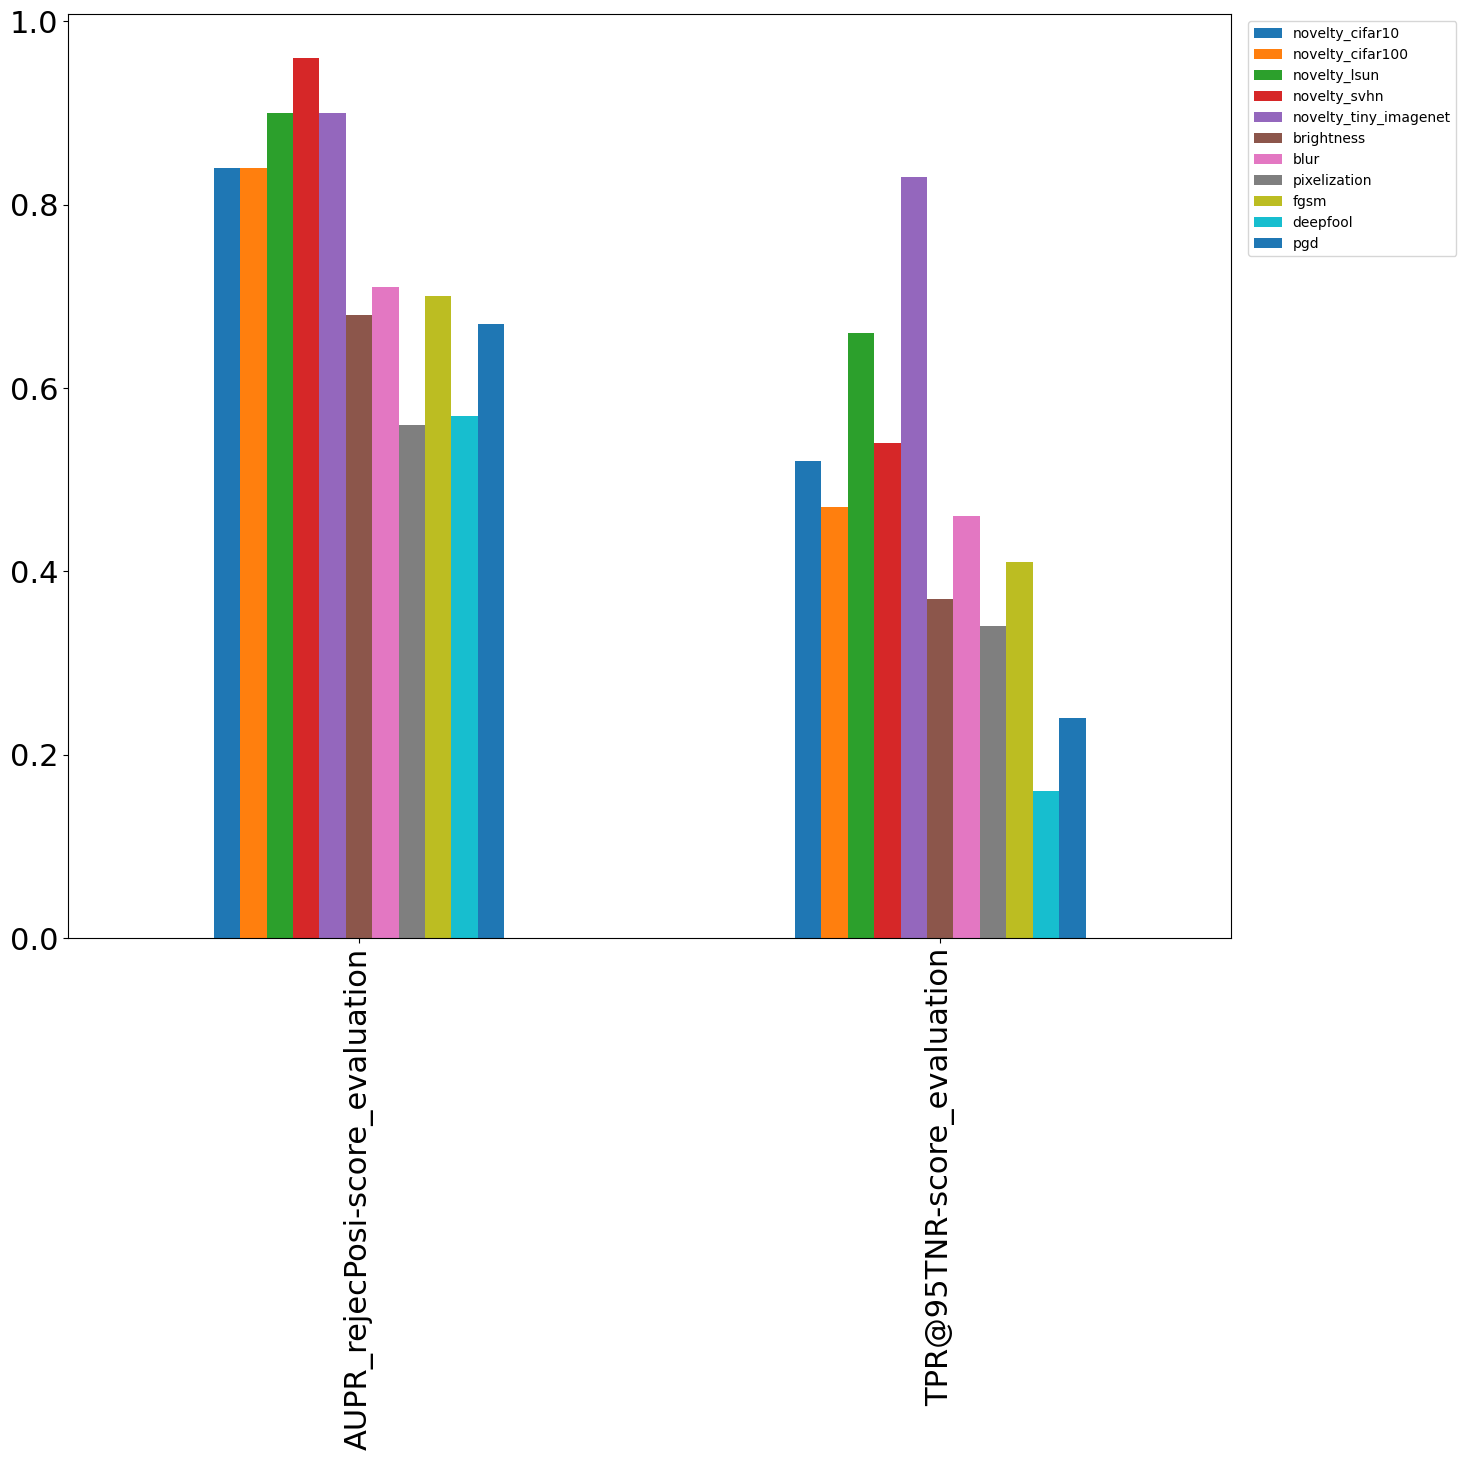

In [29]:
axes = table_rankingmetric_perood.iloc[:, 4:].T.plot.bar(rot=90, subplots=False)
axes.legend(bbox_to_anchor= (1.2,1), fontsize=10)


### Plot threshold distribution (MSP)

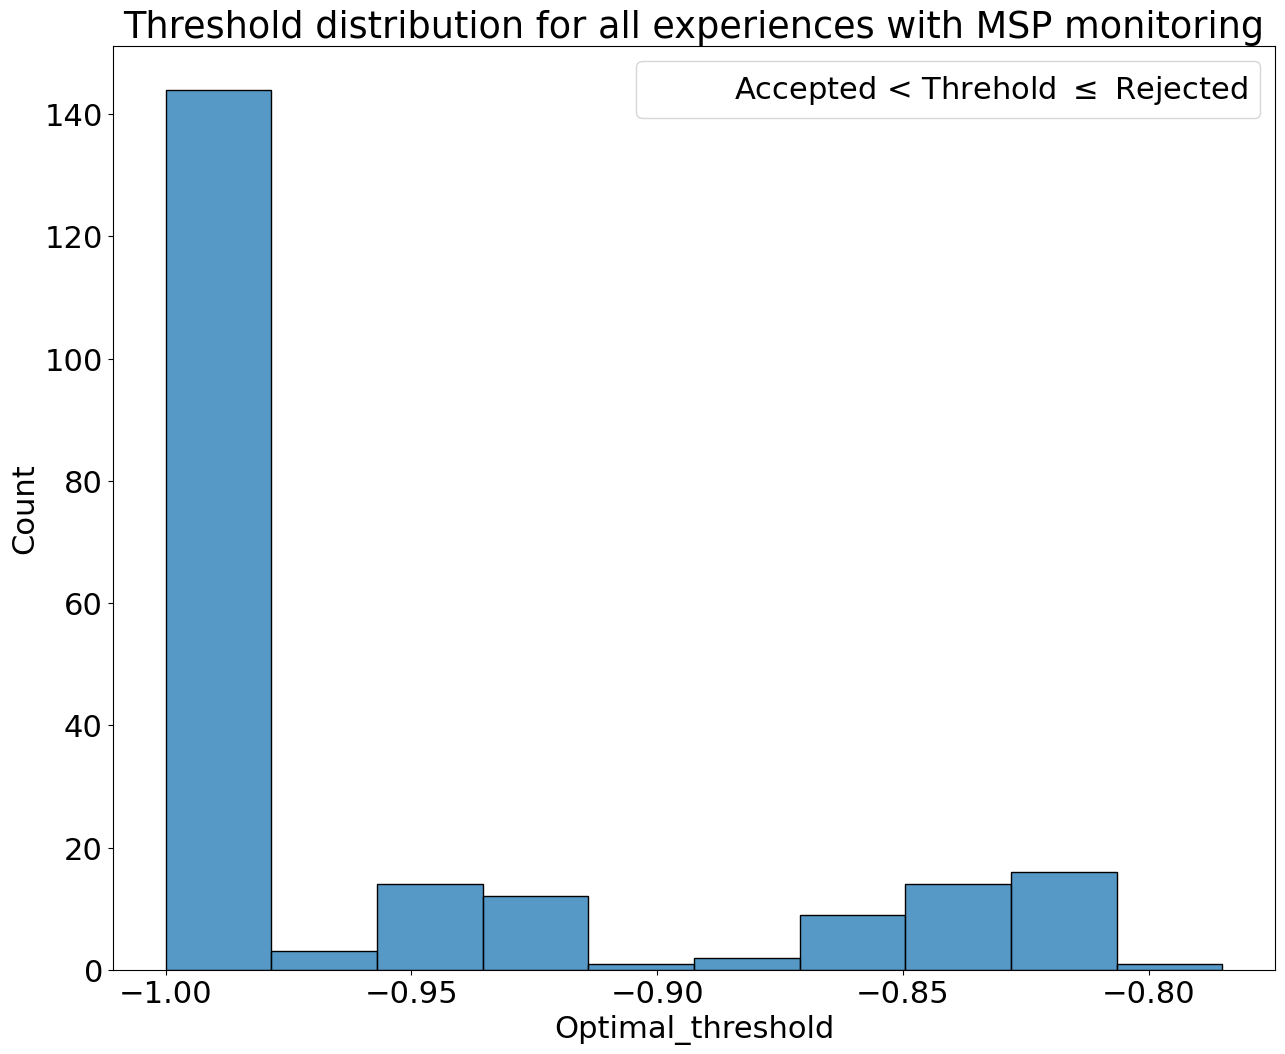

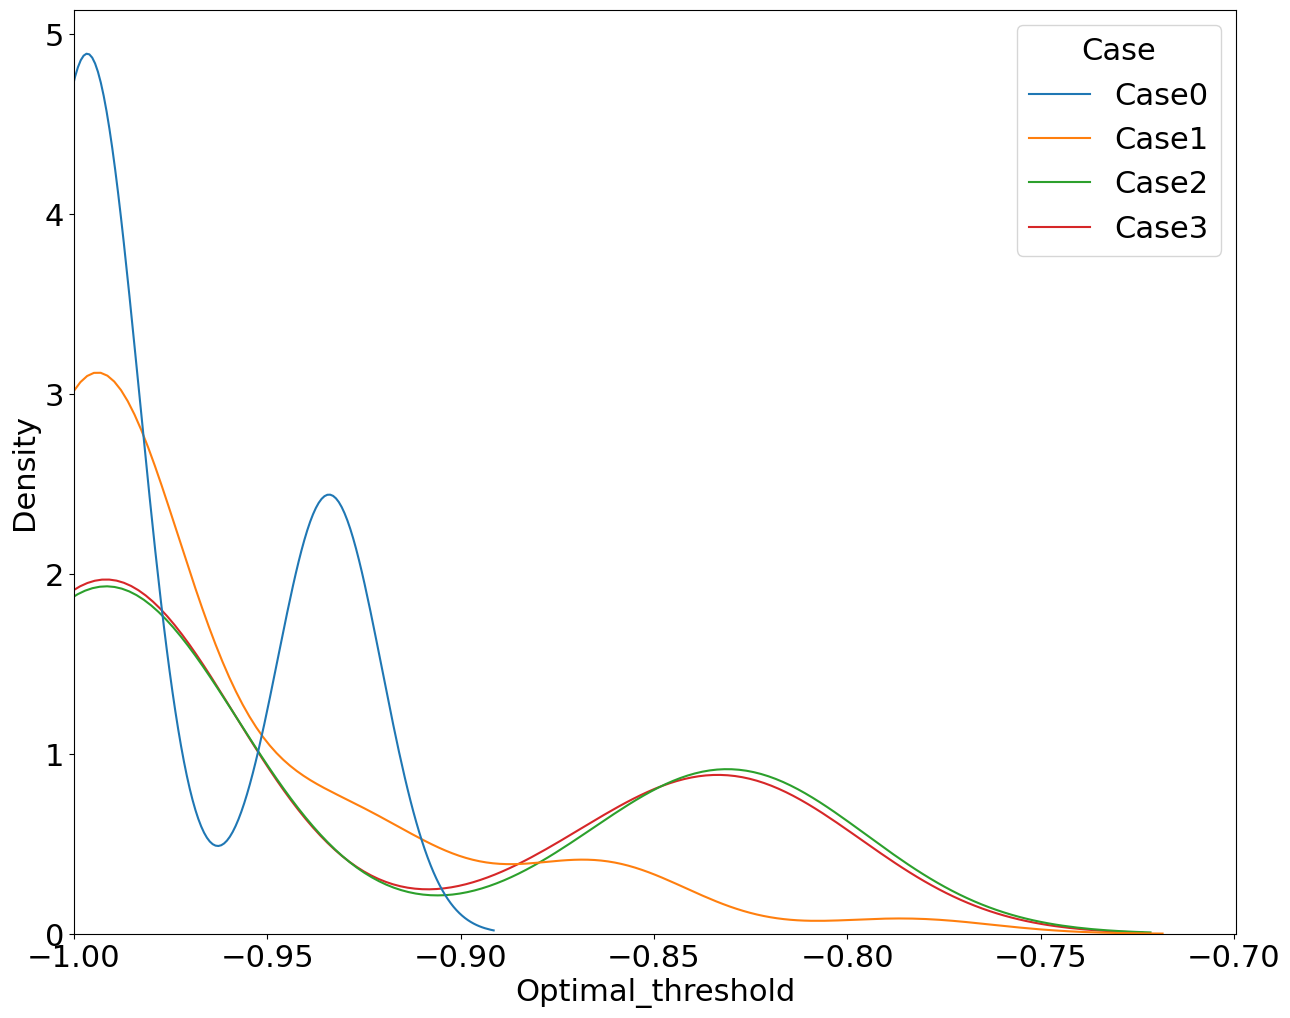

In [30]:
results_df_all = pd.read_csv(path_csv_results + 'Result-Thresh-Opt.csv')
results_df_all = results_df_all[results_df_all['Optimal approach']=='gmean']

monitor_concerned =  'MaxSoftmaxProbabilityMonitor'
results_used = results_df_all[results_df_all["Monitor"]==monitor_concerned]

sns.histplot(data=results_used['Optimal_threshold'])
plt.plot([], [], ' ', label="Accepted < Threhold $\leq$ Rejected")
plt.legend()
plt.title('Threshold distribution for all experiences with MSP monitoring')
plt.show()

sns.kdeplot(data=results_used, x='Optimal_threshold', hue='Case')
plt.xlim(xmin=-1)
plt.show()



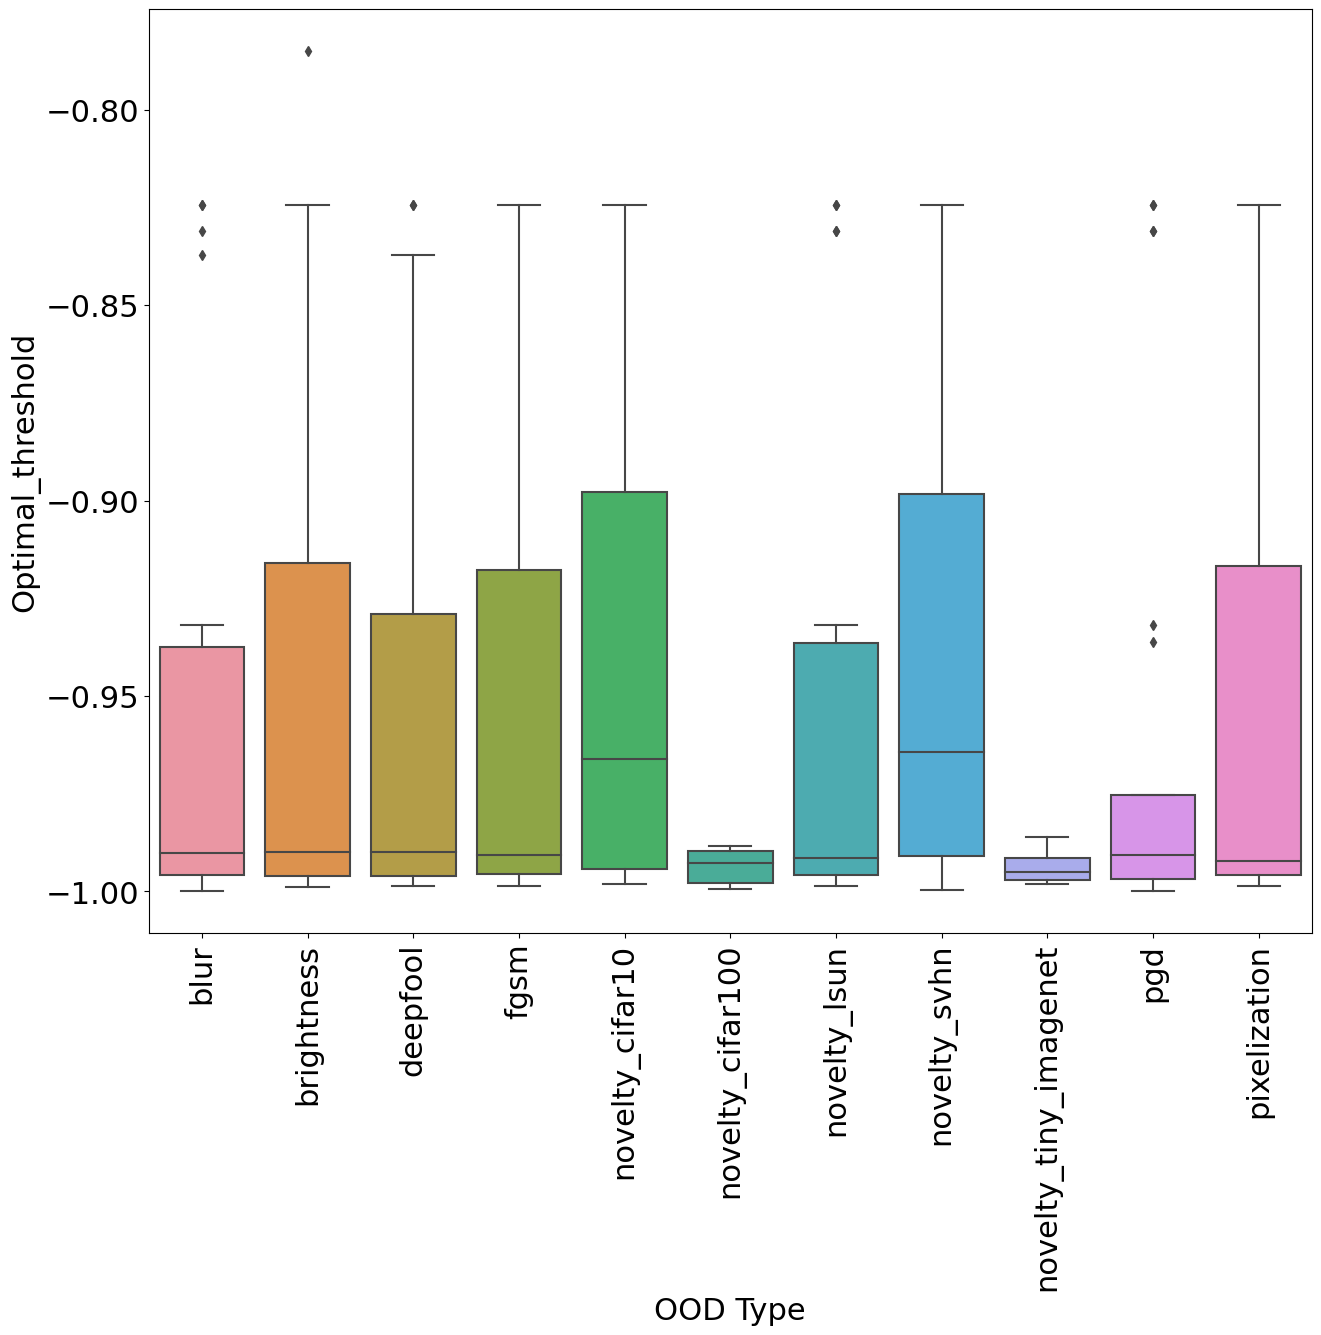

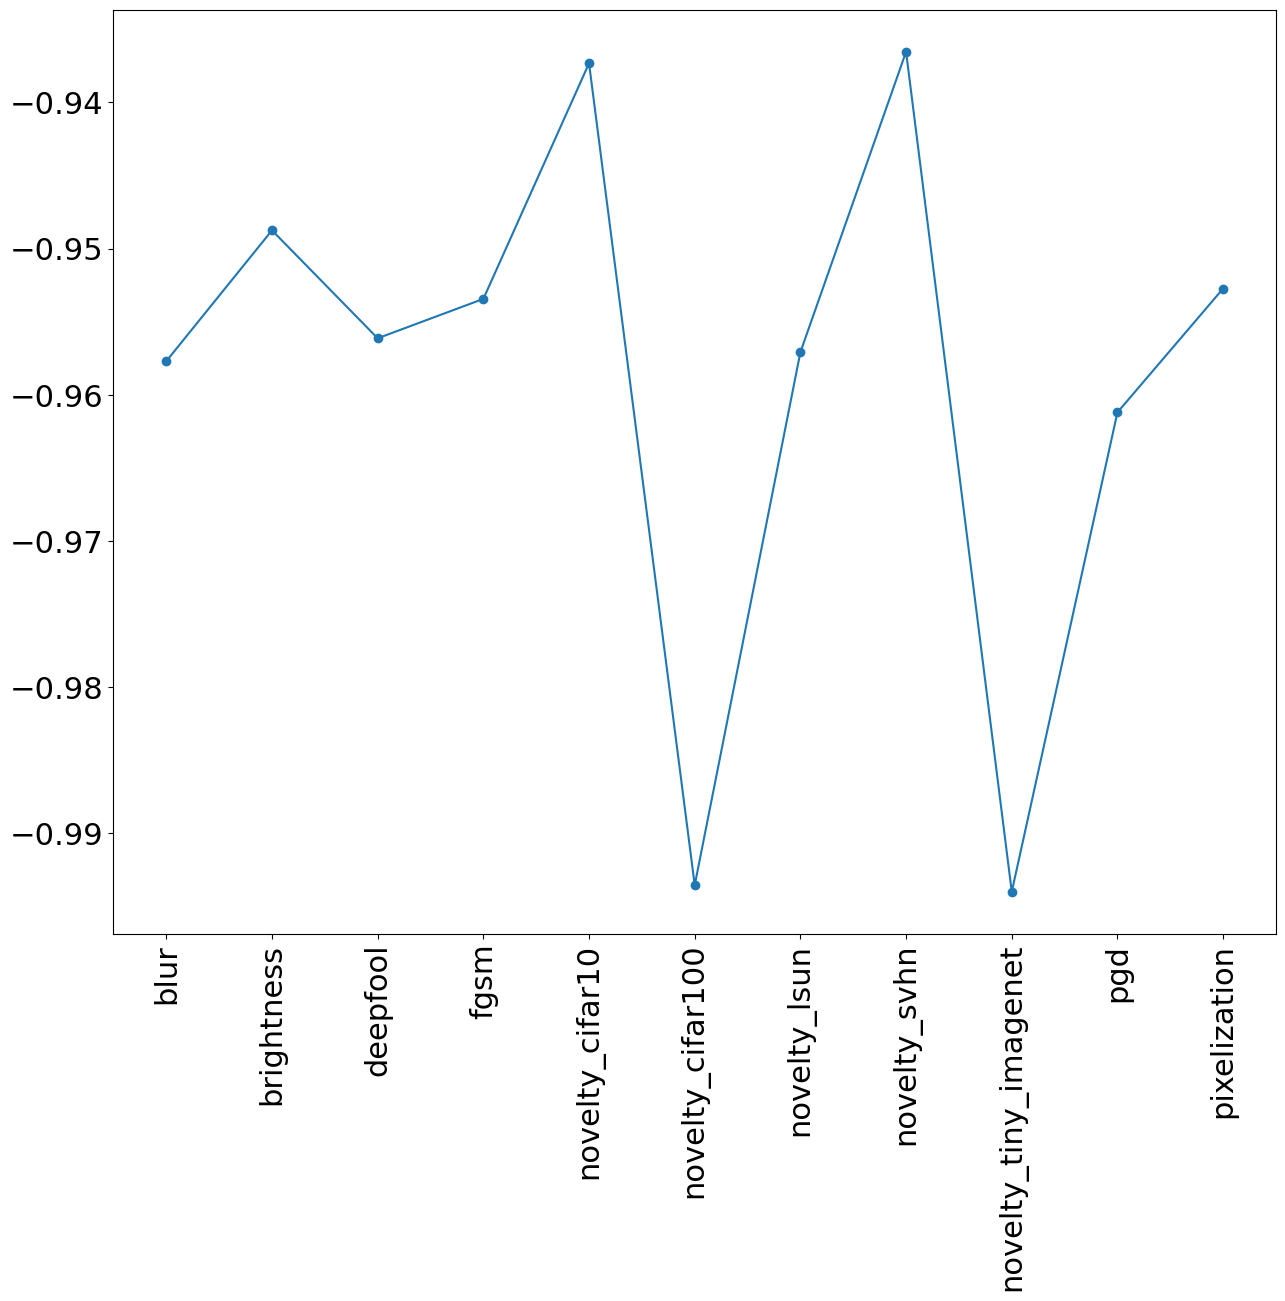

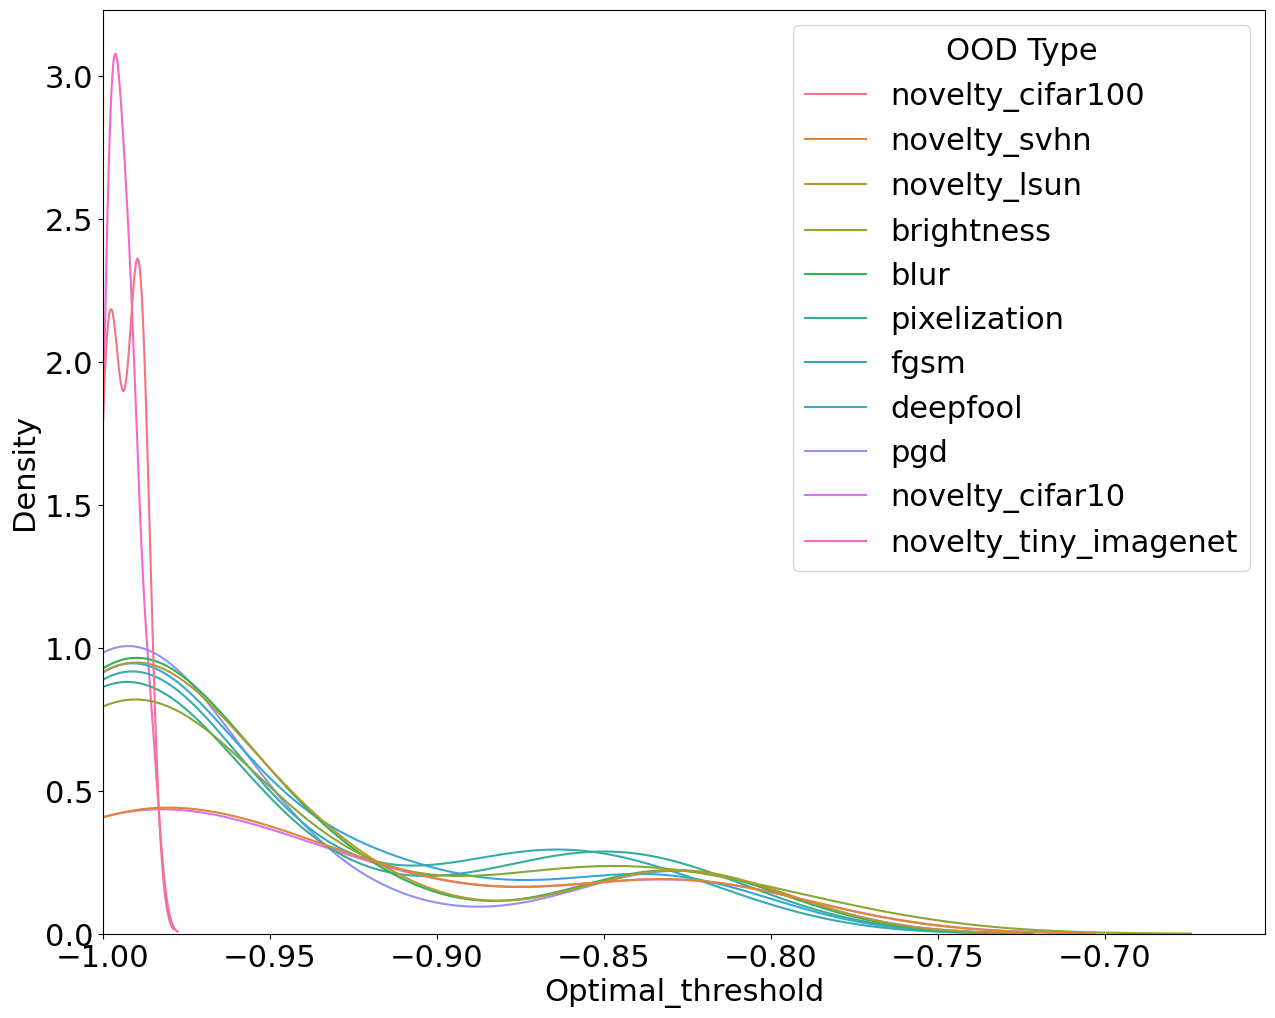

In [31]:
sns.boxplot(data=results_used, x='OOD Type', y='Optimal_threshold', 
            order=sorted(results_used['OOD Type'].unique().tolist()))
plt.xticks(rotation = 90)
plt.show()

plt.plot(results_used.groupby('OOD Type')['Optimal_threshold'].mean(), 'o-')
plt.xticks(rotation = 90)
plt.show()

sns.kdeplot(data=results_used, x='Optimal_threshold', hue='OOD Type')
plt.xlim(xmin=-1)
plt.show()


### Plot threshold distribution (OTB)

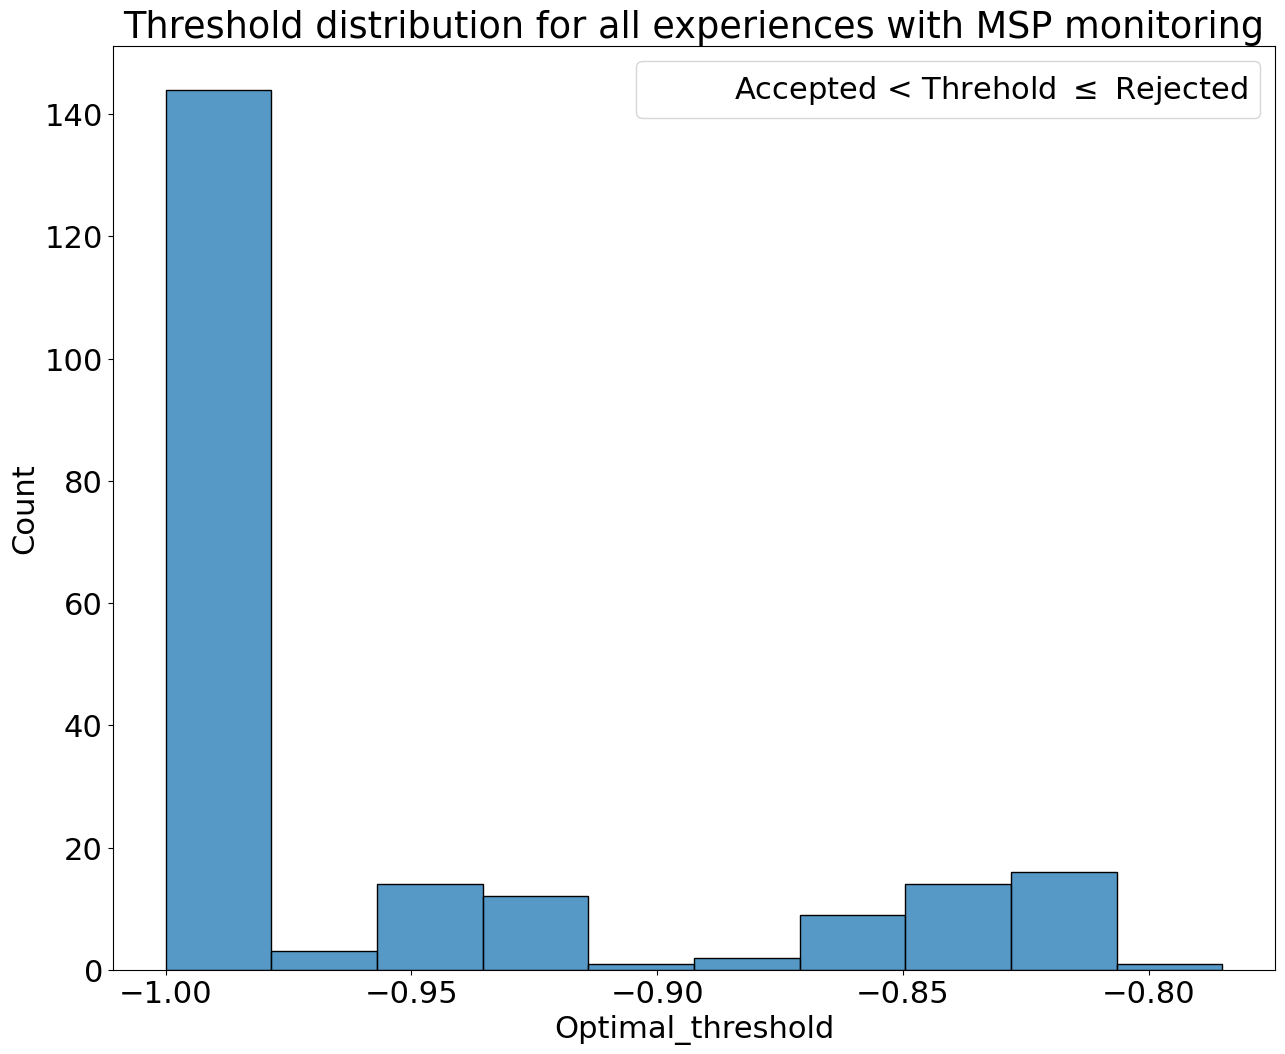

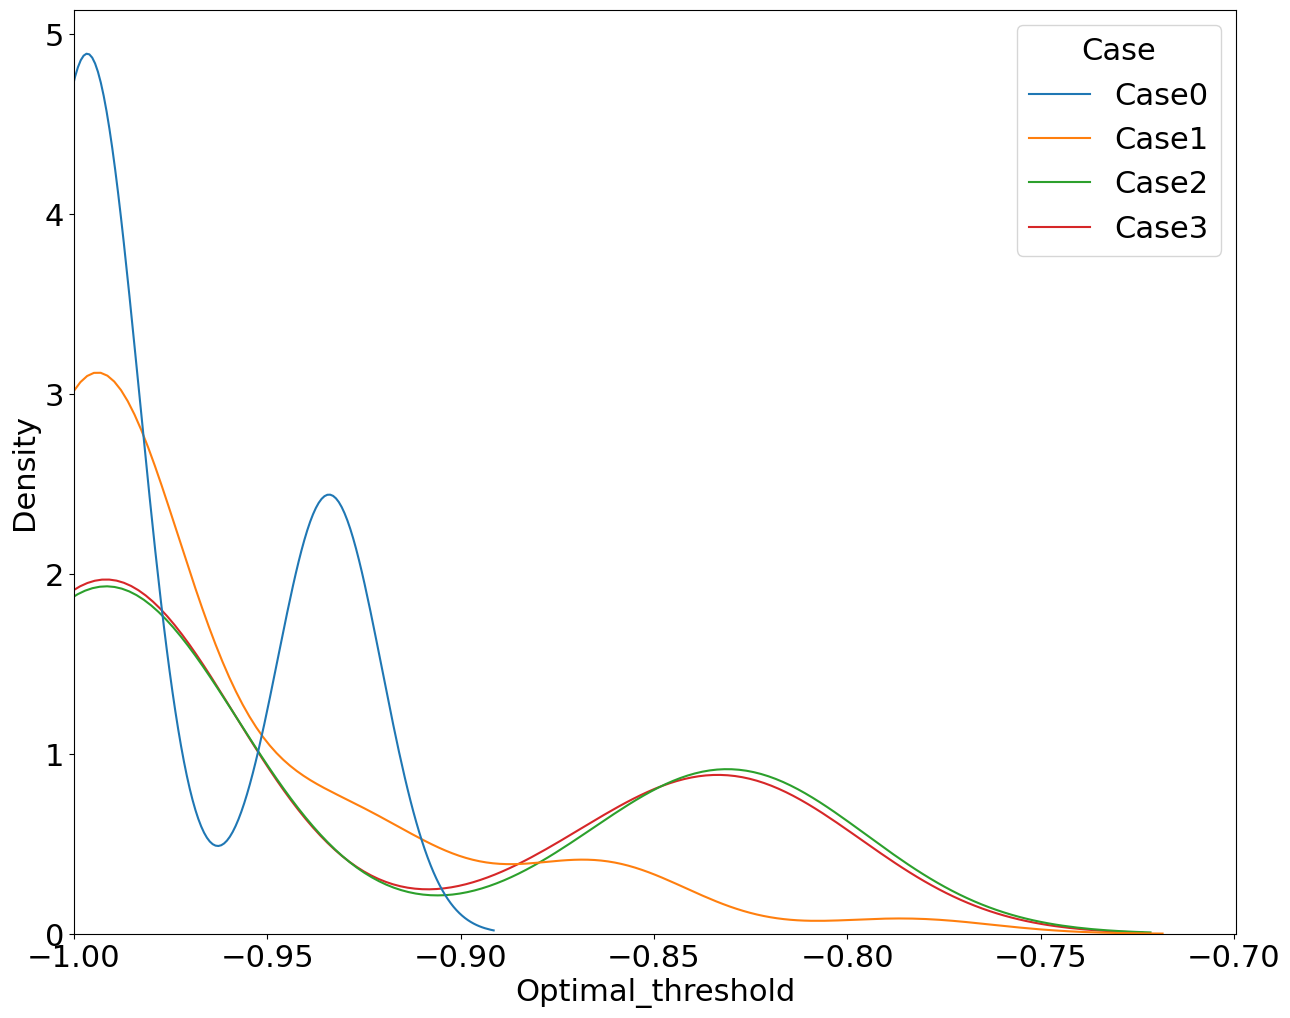

In [32]:
results_df_all = pd.read_csv(path_csv_results + 'Result-Thresh-Opt.csv')
results_df_all = results_df_all[results_df_all['Optimal approach']=='gmean']

monitor_concerned =  'MaxSoftmaxProbabilityMonitor'
results_used = results_df_all[results_df_all["Monitor"]==monitor_concerned]

sns.histplot(data=results_used['Optimal_threshold'])
plt.plot([], [], ' ', label="Accepted < Threhold $\leq$ Rejected")
plt.legend()
plt.title('Threshold distribution for all experiences with MSP monitoring')
plt.show()

sns.kdeplot(data=results_used, x='Optimal_threshold', hue='Case')
plt.xlim(xmin=-1)
plt.show()


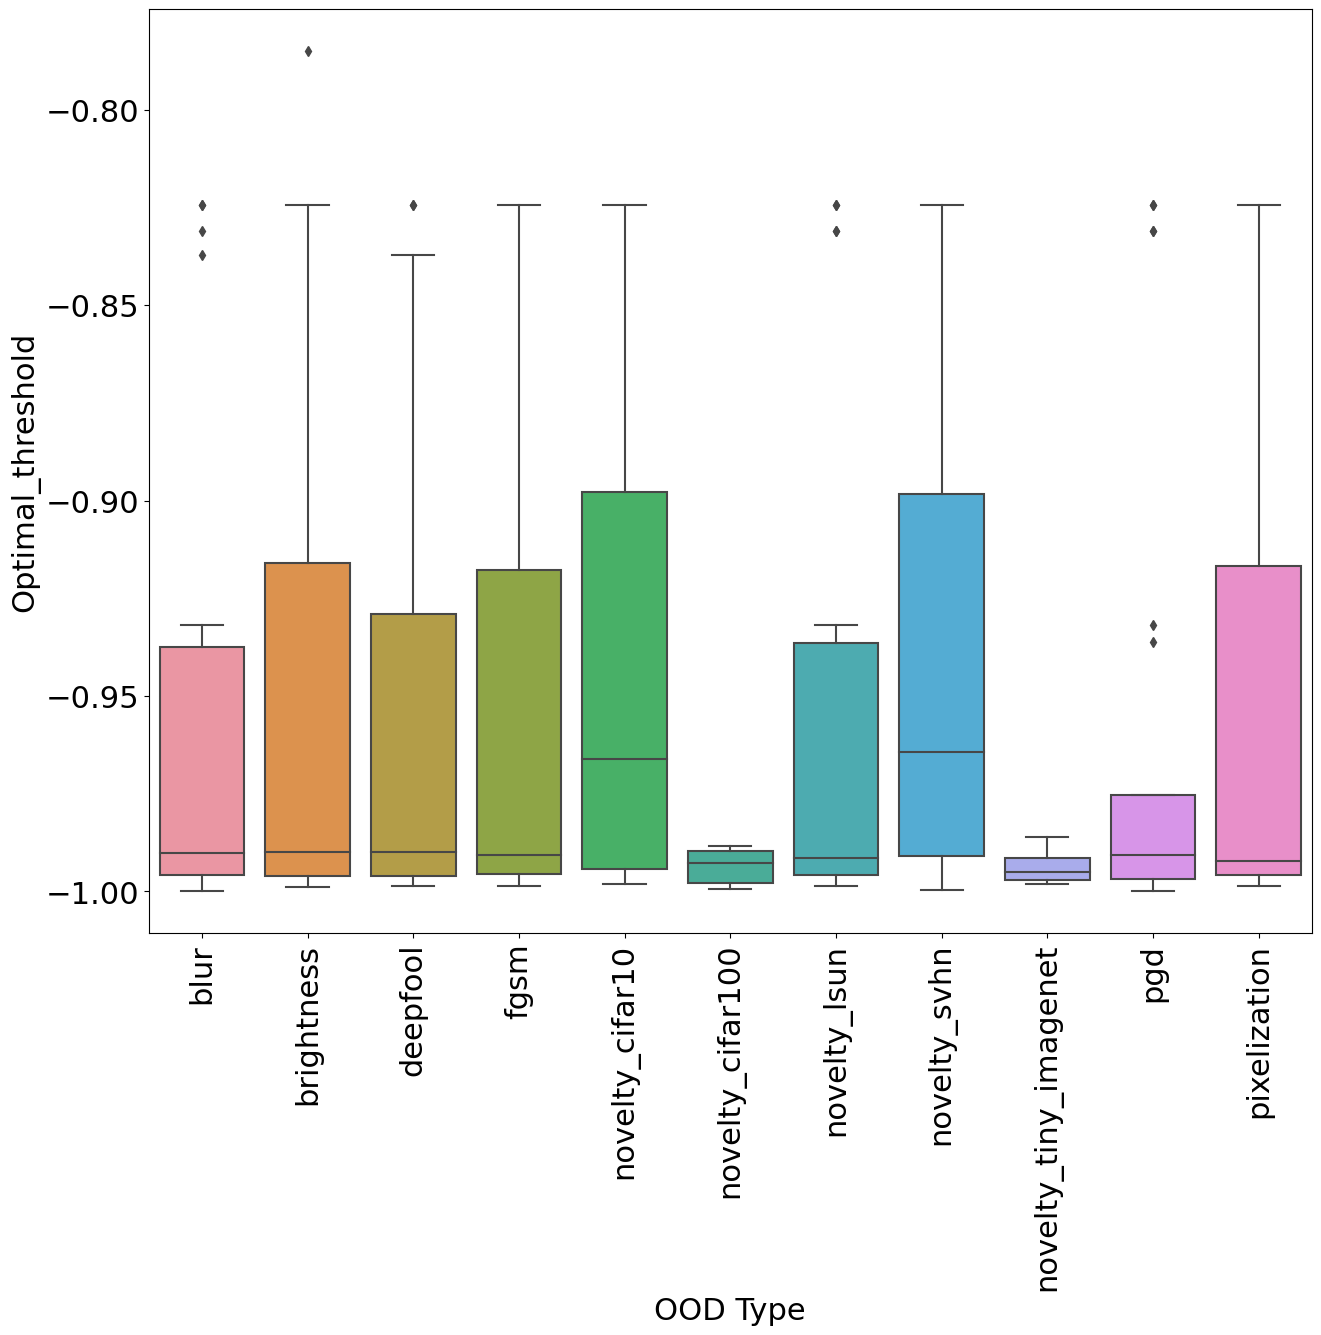

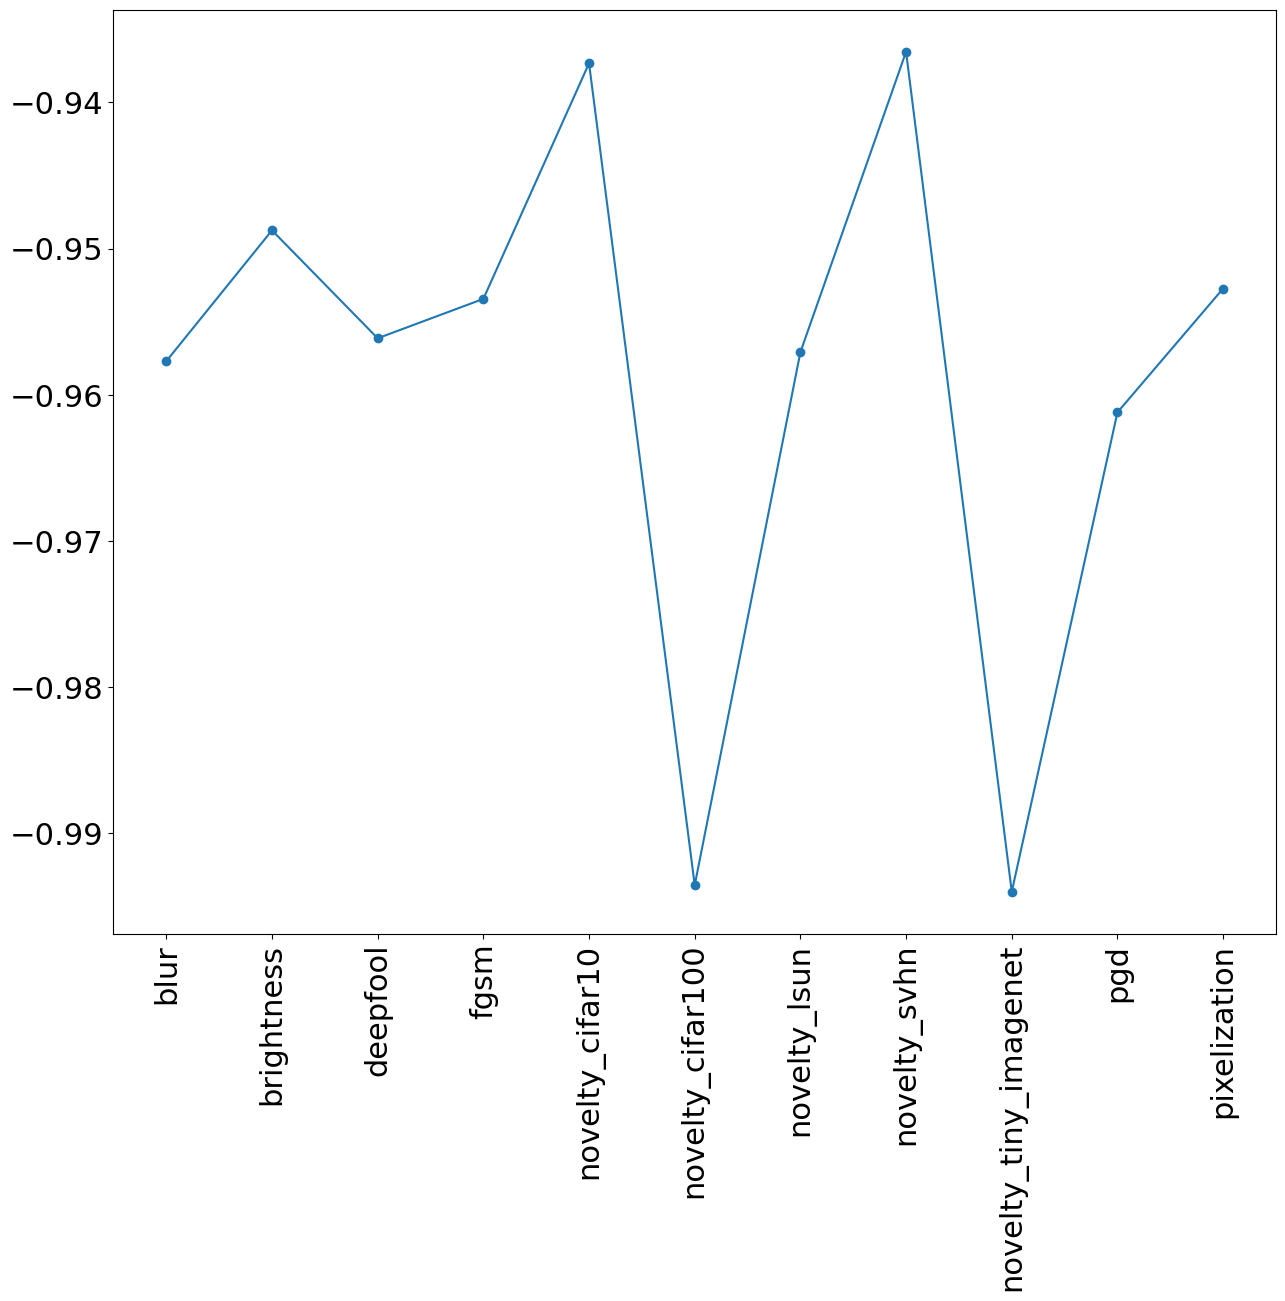

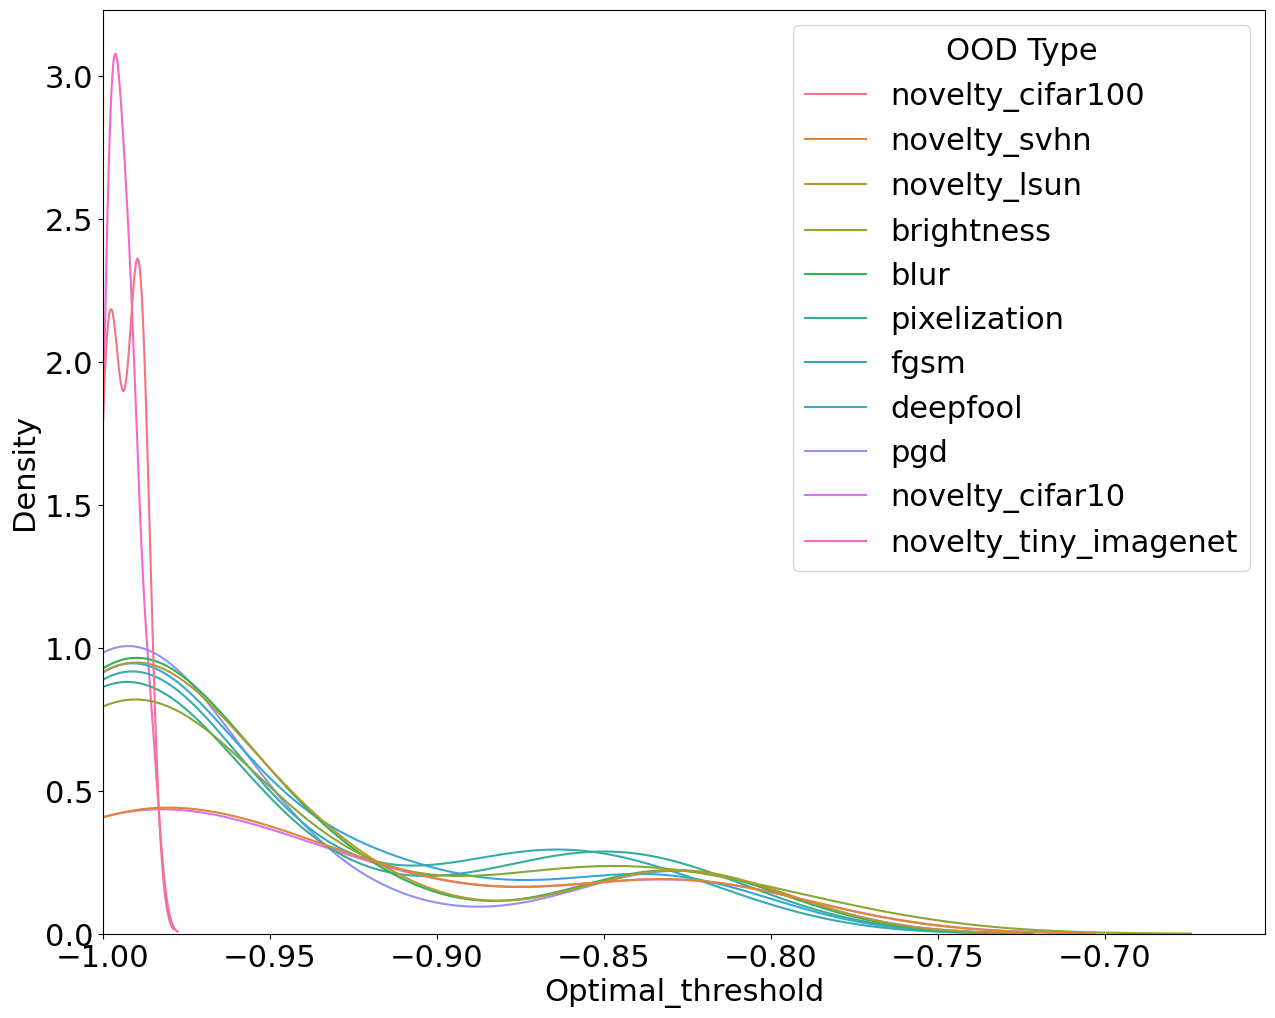

In [33]:
sns.boxplot(data=results_used, x='OOD Type', y='Optimal_threshold', 
            order=sorted(results_used['OOD Type'].unique().tolist()))
plt.xticks(rotation = 90)
plt.show()

plt.plot(results_used.groupby('OOD Type')['Optimal_threshold'].mean(), 'o-')
plt.xticks(rotation = 90)
plt.show()

sns.kdeplot(data=results_used, x='Optimal_threshold', hue='OOD Type')
plt.xlim(xmin=-1)
plt.show()
